# Import 

In [1]:
%matplotlib inline

import os
import math
import time
import copy
import glob
from pathlib import Path
from functools import partial
from inspect import isfunction
from itertools import combinations

import cv2
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image, ImageFilter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from einops.layers.torch import Rearrange
from einops import rearrange, reduce, repeat
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision
from torch import nn, einsum
import torch.utils.data as data
import torch.nn.functional as F
from torchvision import transforms
from torch.cuda.amp import autocast
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from pytorch_fid.inception import InceptionV3
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

from utils import *
from unet import Unet
from fannet import FANnet
from style_encoder import StyleEncoder
from data_loader import make_data_loader

/home/tetta/.local/share/virtualenvs/research-vbjgNxHm/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


# Parameter

In [2]:
device = 'cuda:0'
image_size = 64
batch_size = 128

# model_path = './weight/log23_S2074_cfg_step_100000.pth' # w/o style encoder, 2074font, Aのみ
# model_path = './weight/log24_S2074_cfg_step_20000.pth' # w/ style encoder, 2074font, Aのみ
# model_path = './weight/log24_S2074_cfg_step_40000.pth' # w/ style encoder, 2074font, Aのみ
# model_path = './weight/log25_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ
# model_path = './weight/log26_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ, DA: 上下左右
# model_path = './weight/log27_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ, DA: 上下
# model_path = './weight/log28_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ, DA: 上下, 拡大縮小
# model_path = './weight/log29_S13938_cfg_step_final.pth' # w/ style encoder, 13938font (myfonts), Aのみ, DA: 上下左右, 拡大縮小
# model_path = './weight/log33_fannet_step_final.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,
# model_path = './weight/log34_fannet2_step_final.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,

# style に文字, fannet
# model_path = './weight/log33_fannet_step_320000.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,

# 平均スタイル，fannet
# model_path = './weight/log36_fannet_step_180000.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,

# 平均スタイル, fannet_retrain, dataloaderのencoder要確認
# model_path = './weight/log38_fannet_retrain_step_final.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,
model_path = './weight/log39_fannet_retrain_step_final.pth' # w/ style encoder, 13938font (myfonts), A-Z, DA: 上下左右,

# encoder_name = model_path.split('_')[1]
encoder_name = model_path.split('_')[1] + ('_' + model_path.split('_')[2] if model_path.split('_')[2] != 'step' else '')

# encoder_path = './weight/style_encoder.pth' # google fontsで学習
encoder_path = f'./weight/style_encoder_{encoder_name}.pth'

seed = 7777
da_rate = 0.
channels = 1
unet_dim = 128 # 32 or 128
num_class = 26
timesteps = 1000
cond_drop_prob = 0.1
dataset_name = 'myfonts' # 'myfonts' or 'google_fonts'
style_encoder_zdim = 128
use_style_encoder = True
unet_dim_mults = (1, 2, 4, 8,)
# num_style = int(model_path.split('/')[-1].split('_')[1][1:])

freeze_seed(seed)

# define betas
betas = cosine_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0) # alpha_var
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # [1. , *alphas_cumpprod[:-1]]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
# 順方向の拡散過程
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # どのくらい元画像を残すか，徐々に小さくなる
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # どのくらいノイズを加えるか，徐々に大きくなる
log_one_minus_alphas_cumprod = torch.log(1. - alphas_cumprod)
sqrt_recip_alphas_cumprod = torch.sqrt(1. / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = torch.sqrt(1. / alphas_cumprod - 1)

# calculations for posterior q(x_{t-1} | x_t, x_0)
# 逆方向の拡散過程
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # sigma_t^2 どのくらいノイズを加えるか，徐々に小さくなる．非常に小さい

# forward diffusion (using the nice property)
@autocast(enabled = False)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

@torch.no_grad()
def p_sample(model, x, classes, style, t, t_index, class_scale=3., style_scale=3., rescaled_phi=0.):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    pred_noise = model.forward_with_cond_scale(x, t, classes, style, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, classes, style, shape, class_scale=3., style_scale=3., rescaled_phi=0.):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        img = p_sample(model, img, classes, style, t, i, class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)
    return img

@torch.no_grad()
def sample(model, classes, style, image_size, batch_size=16, channels=3, class_scale=1., style_scale=3., rescaled_phi=0.):
    return p_sample_loop(model, classes, style, shape=(batch_size, channels, image_size, image_size), class_scale=class_scale, style_scale=style_scale, rescaled_phi=rescaled_phi)


@torch.no_grad()
def ddim_sample(model, classes, style, scale=1.):
    batch, total_timesteps, sampling_timesteps, eta = style.shape[0], timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    img = torch.randn((batch, 1, image_size, image_size), device = device)

    x_start = None

    for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
        t = torch.full((batch,), time, device=device, dtype=torch.long)
        pred_noise = model.forward_with_cond_scale(img, t, classes, style, scale=scale)
        x_start  = extract(sqrt_recip_alphas_cumprod, t, img.shape) * img -\
                        extract(sqrt_recipm1_alphas_cumprod, t, img.shape) * pred_noise

        if time_next < 0:
            img = x_start
            continue

        alpha = alphas_cumprod[time]
        alpha_next = alphas_cumprod[time_next]

        sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
        c = (1 - alpha_next - sigma ** 2).sqrt()

        noise = torch.randn_like(img)

        img = x_start * alpha_next.sqrt() + \
                c * pred_noise + \
                sigma * noise

    return img

@torch.no_grad()
def p_sample_noise_interpolate(model, x, style1, style2, t, style_scale, alpha=0.5):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # predict noise
    style1_noise = model.forward_with_cond_scale(x, t, style1, style_scale=style_scale, rescaled_phi=0.)
    style2_noise = model.forward_with_cond_scale(x, t, style2, style_scale=style_scale, rescaled_phi=0.)

    # style interpolation
    pred_noise = alpha * style1_noise + (1 - alpha) * style2_noise

    # sampling
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t[0].item() == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_emb_interpolate(model, x, style1, style2, t, style_scale=3., alpha=0.5):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    cond_logits = model.forward_with_emb_interpolate(x, t, style1, style2, alpha=alpha, style_drop_prob=0.)
    nocond_logits = model.forward_with_emb_interpolate(x, t, style1, style2, alpha=alpha, style_drop_prob=1.)
    pred_noise = nocond_logits + style_scale*(cond_logits - nocond_logits)

    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t[0].item() == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

def imscatter(x,y,image_list,_ax=None,zoom=0.2,color=['black']):
    for i in range(len(image_list)):
        if len(color) < len(image_list):
            color.append(color[0])
        if _ax is None:
            _ax = plt.gca()
        image = image_list[i] #plt.imread(image_list[i])
        im = OffsetImage(image,zoom=zoom)
        artists = []
        x0 = x[i]
        y0 = y[i]
        ab = AnnotationBbox(im,(x0,y0),xycoords='data',frameon=True,bboxprops=dict(color=color[i]))
        artists.append(_ax.add_artist(ab))
    return artists

# Load data

In [3]:
margin = 5 # 5で学習
dataloader = make_data_loader(batch_size, image_size, num_class, encoder_name, device, dataset_name, da_rate, margin=margin)
d = dataloader['train'].dataset
d_val = dataloader['val'].dataset
d_test = dataloader['test'].dataset

DATASET NAME IS myfonts
STYLE ENCODER IS fannet_retrain


TRAIN SIZE: 362388
VAL SIZE: 45084
TEST SIZE: 45240


In [3]:
margin = 40
dataloader_google = make_data_loader(batch_size, image_size, num_class, encoder_name, device, 'google_fonts', da_rate, margin=margin)
d_google = dataloader_google['train'].dataset
d_google_val = dataloader_google['val'].dataset
d_google_test = dataloader_google['test'].dataset

DATASET NAME IS google_fonts
STYLE ENCODER IS fannet_retrain
TRAIN SIZE: 53924
VAL SIZE: 5980
TEST SIZE: 6266


[0.57569407 0.11513037 0.07939748]


/tmp/ipykernel_1798078/3212643677.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(X_reduced[i:i+img_num, 0], X_reduced[i:i+img_num, 1], 'ko', c=color[i], label=labels[i//img_num])


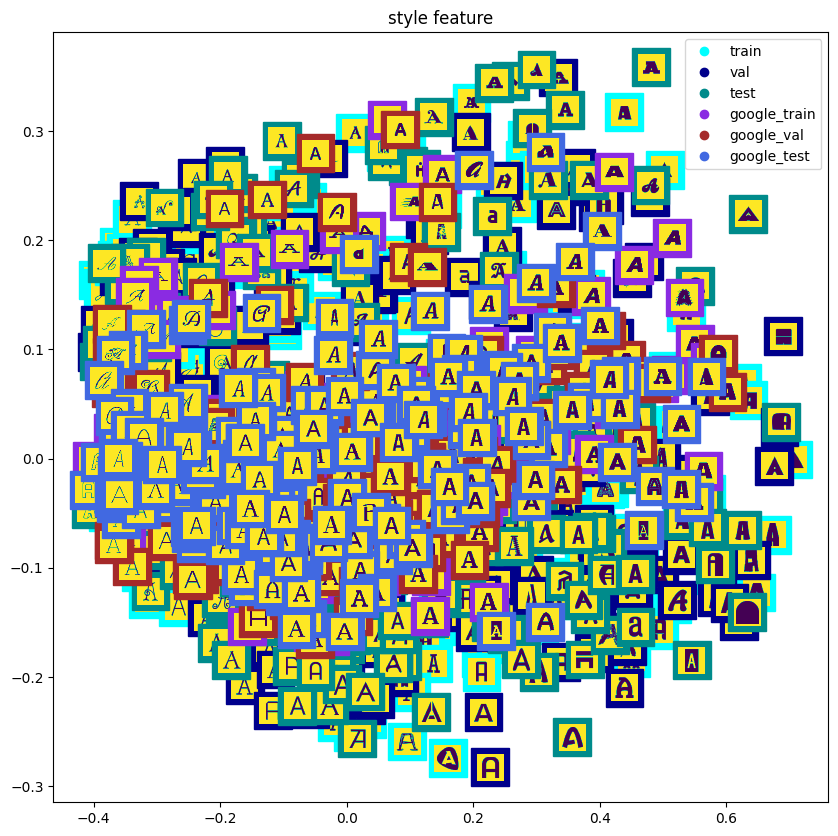

In [27]:
# google fonts とmyfontsのスタイル特徴のギャップ
features = []
imgs = []
color_map = list(matplotlib.colors.CSS4_COLORS.values())
color = []

img_num = 200
with torch.no_grad():
    for i in range(0, 26*img_num, 26):
        img, style, _ = d[i]
        imgs.append(img)
        img = img.to(device)
        features.append(style.cpu().detach().unsqueeze(0))
        color.append(color_map[20])

with torch.no_grad():
    for i in range(0, 26*img_num, 26):
        img, style, _ = d_val[i]
        imgs.append(img)
        img = img.to(device)
        features.append(style.cpu().detach().unsqueeze(0))
        color.append(color_map[21])

with torch.no_grad():
    for i in range(0, 26*img_num, 26):
        img, style, _ = d_test[i]
        imgs.append(img)
        img = img.to(device)
        features.append(style.cpu().detach().unsqueeze(0))
        color.append(color_map[22])

with torch.no_grad():
    for i in range(0, 26*img_num, 26):
        img, style, _ = d_google[i]
        imgs.append(img)
        img = img.to(device)
        features.append(style.cpu().detach().unsqueeze(0))
        color.append(color_map[10])

with torch.no_grad():
    for i in range(0, 26*img_num, 26):
        img, style, _ = d_google_val[i]
        imgs.append(img)
        img = img.to(device)
        features.append(style.cpu().detach().unsqueeze(0))
        color.append(color_map[11])

with torch.no_grad():
    for i in range(0, 26*img_num, 26):
        img, style, _ = d_google_test[i]
        imgs.append(img)
        img = img.to(device)
        features.append(style.cpu().detach().unsqueeze(0))
        color.append(color_map[122])


features = torch.cat(features, dim=0)
imgs = torch.cat(imgs, dim=0).squeeze(1)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
fig, ax = plt.subplots(figsize=(10,10))
imscatter(X_reduced[:, 0], X_reduced[:, 1], imgs, _ax=ax, zoom=0.3 ,color=color)
labels = ['train', 'val', 'test', 'google_train', 'google_val', 'google_test']
for i in range(0, imgs.size(0), img_num):
    ax.plot(X_reduced[i:i+img_num, 0], X_reduced[i:i+img_num, 1], 'ko', c=color[i], label=labels[i//img_num])
ax.legend()
ax.set_title('style feature')
# plt.savefig(f'result/style_encoder_{model_name}_feature_A-Z_retrain.png')
plt.show()

# Load trained model

In [4]:
model = Unet(
    dim=unet_dim,
    channels=channels,
    dim_mults=unet_dim_mults,
    num_class=num_class,
    cond_drop_prob=cond_drop_prob,
)
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print(f'ok {model_path}')

ok ./weight/log39_fannet_retrain_step_final.pth


# style encoder の特徴の可視化

TRAIN SIZE: 362388
VALID SIZE: 45084
TEST SIZE: 45240
[0.37703903 0.07630152 0.06337488]


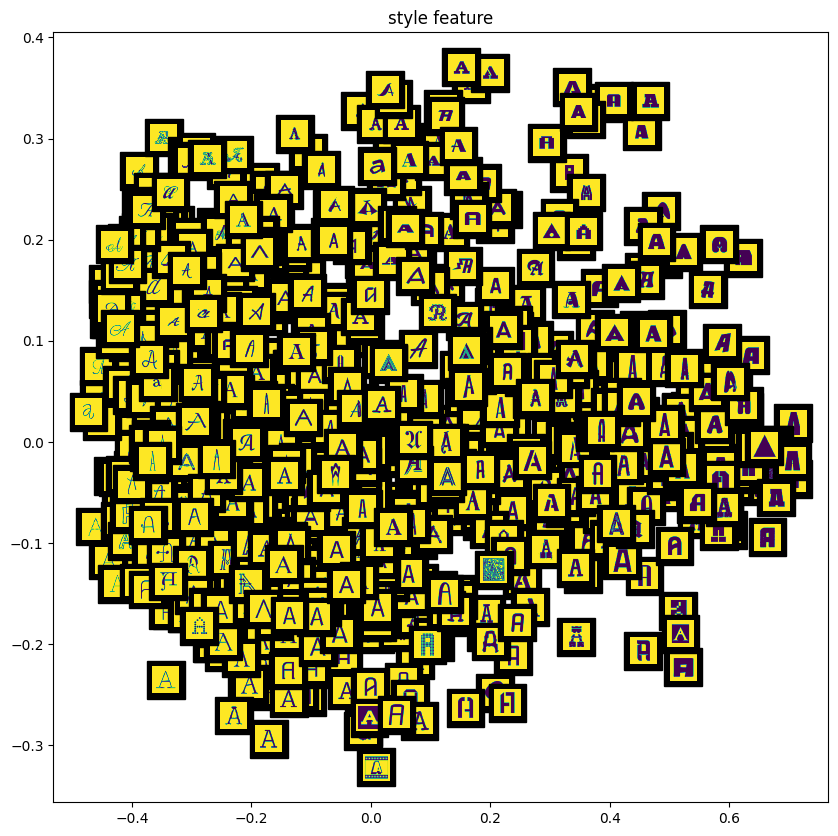

In [27]:
model_name = 'fannet'
if model_name == 'fannet':
    model = FANnet(num_class).to(device)
elif model_name == 'fannet2':
    model = StyleEncoder(num_class).to(device)

model.load_state_dict(torch.load(f'weight/style_encoder_{model_name}_retrain.pth', map_location=device))
model.eval()

from train_fannet import make_data_loader as _make_data_loader
_data = _make_data_loader(16, num_class, image_size)['train']

features = []
imgs = []
color_map = list(matplotlib.colors.CSS4_COLORS.values())
color = []
with torch.no_grad():
    for i in range(0, 26*1000, 26):
        img = _data.dataset[i][0]
        imgs.append(img)
        img = img.to(device)
        style = model.style_encode(img.unsqueeze(0))
        features.append(style.cpu().detach())
        # color.append(color_map[i//26])

features = torch.cat(features, dim=0)
imgs = torch.cat(imgs, dim=0).squeeze(1)

pca = PCA(n_components=3)
X_reduced = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
fig, ax = plt.subplots(figsize=(10,10))
imscatter(X_reduced[:, 0], X_reduced[:, 1], imgs, _ax=ax, zoom=0.3)#,color=color)
ax.plot(X_reduced[:, 0], X_reduced[:, 1], 'ko', alpha=0.)
ax.set_title('style feature')
# plt.savefig(f'result/style_encoder_{model_name}_feature_A-Z_retrain.png')
plt.show()

# L1

In [ ]:
with open('result/eval.txt', 'a') as f:
    f.write('\n============\n')
    f.write(f"{model_path.split('/')[-1]}\n")


for scale in [1., 3., 5.]:
    style_scale = scale
    rescaled_phi = 0.

    loss = nn.L1Loss()
    total_loss = 0.

    num_try_cnt = 10
    freeze_seed(seed)
    for i, (gt, style, classes) in enumerate(dataloader['train']):
        if i == num_try_cnt:
            break

        gt = gt.to(device)
        style = style.to(device)
        classes = classes.to(device)
        output = ddim_sample(model, classes, style, class_scale=scale, style_scale=scale)


        total_loss += loss(torch.clamp(output, min=-1., max=1.), gt).item()

    total_loss /= num_try_cnt

    # eval.txt は全モデルで共通
    with open('result/eval.txt', 'a') as f:
        f.write(f'\tscale: {scale}, l1 loss: {total_loss}\n')

# condition 指定して生成

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

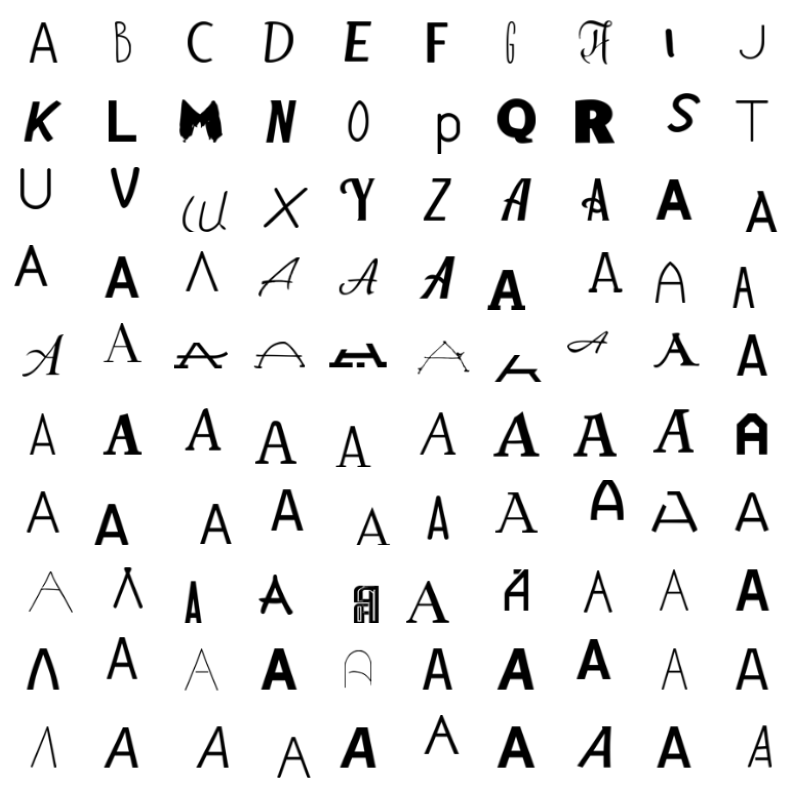

In [5]:
class_scale = 1.
rescaled_phi = 0.
ddim_sampling = True

scale_list = [1.]

for ss in scale_list:
    if ddim_sampling == False:
        save_path1 = f"result/{os.path.basename(model_path).split('.')[0]}_generated1_{dataset_name}_s_{ss}_c_{class_scale}.png"
    else:
        save_path1 = f"result/{os.path.basename(model_path).split('.')[0]}_generated1_{dataset_name}_ddim_s_{ss}_c_{class_scale}.png"
        # save_path1 = f"result/{os.path.basename(model_path).split('.')[0]}_generated1_googlefonts_ddim_s_{ss}_c_{class_scale}.png"

    b = 100
    # style = torch.cat([d[26*i][1].unsqueeze(0) for i in range(b)]).to(device)
    # classes = torch.tensor([d[26*i][2] for i in range(b)]).to(device)
    classes = torch.tensor([i for i in range(26)] + [0]*74, device=device)
    # style = torch.cat([dataloader['train'].dataset[0][1].unsqueeze(0) for _ in range(26)] + [dataloader['train'].dataset[26*i][1].unsqueeze(0) for i in range(74)]).to(device)
    style = torch.cat([d_google[i][1].unsqueeze(0) for i in range(0, 26*100, 26)]).to(device)

    if ddim_sampling == False:
        samples = sample(model, classes, style, image_size, batch_size=b, channels=channels,
                        class_scale=class_scale, style_scale=ss, rescaled_phi=rescaled_phi)
    else:
        # samples = ddim_sample(model, classes, style, class_scale=class_scale, style_scale=ss)
        samples = ddim_sample(model, classes, style, scale=ss)

    # show images
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        x = i // 10
        y = i % 10
        ax[x, y].axis("off")
        ax[x, y].imshow(samples[i][0].cpu().detach(), cmap="gray")

    plt.savefig(save_path1)
    plt.show()


# GT

## google font

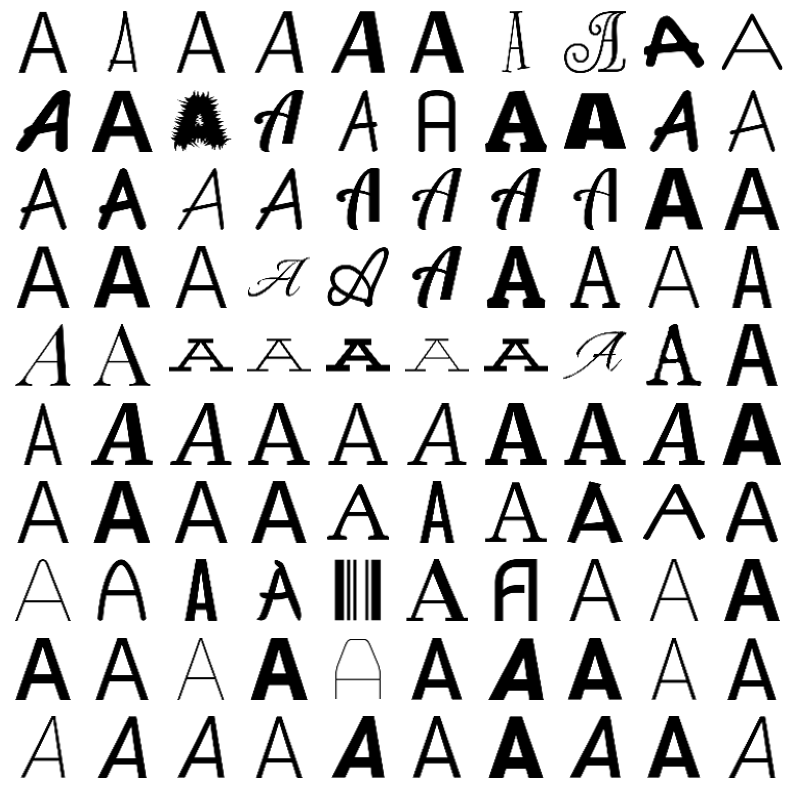

In [ ]:
# 100フォント見る（上から100）
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].imshow(d[i][0][0], cmap='gray')

## myfonts

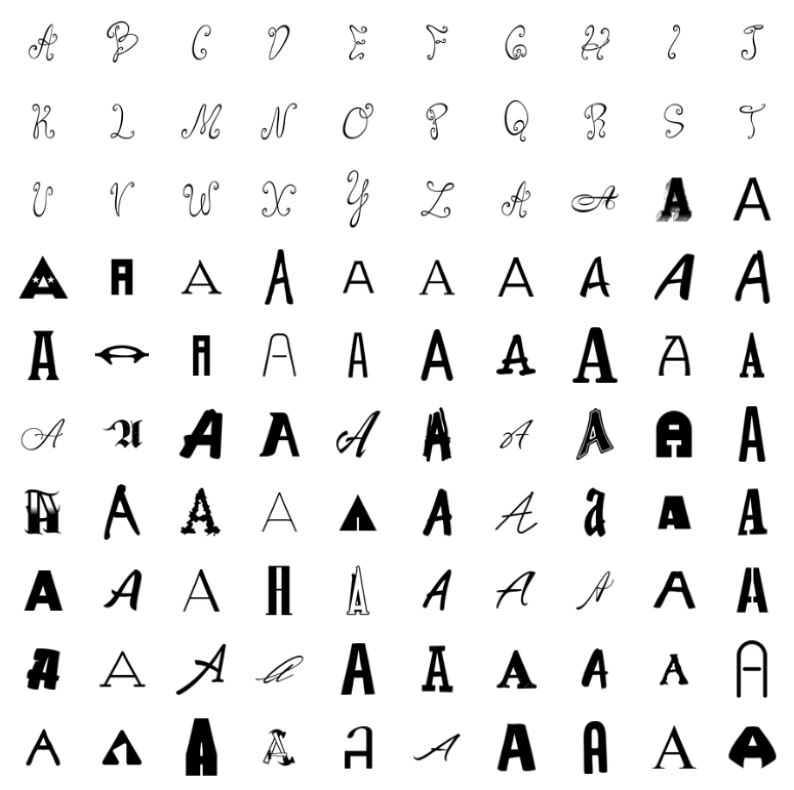

In [24]:
# 100フォント見る（上から100）
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(100):
    ax[i//10, i%10].axis('off')
    if i < 26:
        ax[i//10, i%10].imshow(d[i][0][0], cmap='gray')
    else:
        ax[i//10, i%10].imshow(d[(i-26)*26][0][0], cmap='gray')

In [ ]:
data_type = 'test' # 'train' or 'val' or 'test'

if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for start_i in range(1500, 1700, 100):
    # start_i = 0
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(100):
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].set_title(f'{start_i+i}')
        ax[i//10, i%10].imshow(data[26*(start_i+i)][0][0], cmap='gray')

    plt.tight_layout()
    plt.savefig(f"result/{dataset_name}_{data_type}_from_{start_i}_to_{start_i+100}.png")
    # plt.show()

# ノイズの内挿

## ddpm

In [ ]:
# DDPM
style_scale = 1.
class_scale = 1.
char = 'A'
num_split = 100
interpolation_seed = 1
data_type = 'train' # 'train' or 'val' or 'test'
save_img_parenet_dir = 'result/pick_interpolation/Noise'

freeze_seed(interpolation_seed)

# train
# pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198)]
# pair_id = [(275, 185), (284, 249), ]
# pair_id = [(222, 275), (28, 40), (91, 184)]
pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198),
            (284, 249), (284, 494), (710, 494), (693, 769), (275, 185), (284, 249),
            (91, 406), (80, 471), ]

pair_id = [(222, 275), (91, 494)]
pair_id = [(2, 3), (2, 6)]
# test
# pair_id = [(50, 81), (703, 727), (909, 918), ]

# google font
# pair_id = [(44,45), (90, 91), (20, 21)]

if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test


for s1, s2 in pair_id:
    style1_id = s1
    style2_id = s2

    alphas = torch.tensor([i/(num_split-1) for i in range(num_split)]).to(device)
    b = alphas.shape[0]
    style1 = torch.cat([d[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    style2 = torch.cat([d[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for _ in range(b)])

    with torch.no_grad():
        for t_index in tqdm(reversed(range(0, timesteps))):
            t = torch.full((b,), t_index, device=device, dtype=torch.long)
            betas_t = extract(betas, t, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

            # predict noise
            # style1_noise = model.forward_with_cond_scale(x, t, classes, style1, scale=style_scale)
            # style2_noise = model.forward_with_cond_scale(x, t, classes, style2, scale=style_scale)

            ## 計算量少ないver
            nocond_logits = model(x, t, classes, style1, class_drop_prob=1., style_drop_prob=1.)
            style1_logits = model(x, t, classes, style1, class_drop_prob=0., style_drop_prob=0.)
            style2_logits = model(x, t, classes, style2, class_drop_prob=0., style_drop_prob=0.)

            style1_noise = nocond_logits + style_scale*(style1_logits - nocond_logits)
            style2_noise = nocond_logits + style_scale*(style2_logits - nocond_logits)

            # style interpolation
            pred_noise = torch.cat([alpha*s1 + (1-alpha)*s2 for s1, s2, alpha in zip(style1_noise, style2_noise, alphas)]).unsqueeze(1)

            model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

            if t_index == 0:
                x = model_mean
            else:
                posterior_variance_t = extract(posterior_variance, t, x.shape)
                _noise = torch.randn_like(x)
                x = model_mean + torch.sqrt(posterior_variance_t) * _noise

    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].imshow(x[i][0].cpu().detach(), cmap='gray')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_scale_{class_scale}_{style_scale}_{dataset_name}_char_{char}_style_{style1_id}_{style2_id}.png")
    plt.show()

    # save generated image
    folder_name = f'{dataset_name}_{data_type}_scale_{class_scale}_{style_scale}_{char}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(model_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = [str(i) + '_' + str(a.item()) for i, a in enumerate(alphas)]
    x_from_0_to_1 = torch.clamp((x.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_generated_image(x_from_0_to_1, save_dir, save_filename)

    # save style1 and style2
    style1_and_style2 = torch.cat([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]]).unsqueeze(1)
    style1_and_style2 = torch.clamp((style1_and_style2.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_style_filename = ['style1', 'style2']
    save_generated_image(style1_and_style2, save_dir, save_style_filename)

## ddim

In [ ]:
style_scale = 3.
class_scale = 3.
char = 'A'
num_split = 100
interpolation_seed = 1
data_type = 'test' # 'train' or 'val' or 'test'
save_img_parenet_dir = 'result/pick_interpolation/Noise'


# train
# pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198)]
# pair_id = [(275, 185), (284, 249), ]
# pair_id = [(222, 275), (28, 40), (91, 184)]
# pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198),
#             (284, 494), (710, 494), (693, 769), (275, 185), (284, 249),
#             (91, 406), (80, 471), (2, 3), ]
# pair_id = [(7, 21), (10, 20), (79, 85), (144, 164), (166, 171), (132, 133)]
# pair_id = [(random.randint(0, 13000), random.randint(0, 13000)) for _ in range(10)]
# pair_id = [(56, 184), (77, 222), (460, 461), (24, 40), (521, 550)]

# pair_id = [(222, 275), (91, 494)]
# pair_id = [(2, 3), (2, 6)]
# pair_id = [(710, 494)]


# test
# pair_id = [(50, 81), (703, 727), (909, 918), ]
# pair_id = [(34, 50), (160, 180), (166, 172), (212, 292), (296, 212),
#             (333, 362), (402, 429), (523, 583), (672, 524), (849, 824), ]
# pair_id = [(34, 727), (34, 172), (296, 429), (909, 523) ]
# pair_id = [(81, 727), (50, 727), (50, 172), (50, 524), (172, 296), (524, 849)]
# pair_id = [(1, 6), (323, 386)]

pair_id = [(166, 950)] # seed=5

# pair_id = [(random.randint(0, 1700), random.randint(0, 1700)) for _ in range(20)]


# google font
# pair_id = [(44,45), (90, 91), (20, 21)]

if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for s1, s2 in pair_id:
    freeze_seed(interpolation_seed)
    style1_id = s1
    style2_id = s2
    print(style1_id, style2_id)

    alphas = torch.tensor([i/(num_split-1) for i in range(num_split)]).to(device)
    b = alphas.shape[0]
    style1 = torch.cat([data[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    style2 = torch.cat([data[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for _ in range(b)])

    total_timesteps, sampling_timesteps, eta = timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    x_start = None

    with torch.no_grad():
        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            t = torch.full((b,), time, device=device, dtype=torch.long)

            ## 計算量少ないver
            nocond_logits = model(x, t, classes, style1, class_drop_prob=1., style_drop_prob=1.)
            style1_logits = model(x, t, classes, style1, class_drop_prob=0., style_drop_prob=0.)
            style2_logits = model(x, t, classes, style2, class_drop_prob=0., style_drop_prob=0.)

            style1_noise = nocond_logits + style_scale*(style1_logits - nocond_logits)
            style2_noise = nocond_logits + style_scale*(style2_logits - nocond_logits)

            # style interpolation
            pred_noise = torch.cat([alpha*s1 + (1-alpha)*s2 for s1, s2, alpha in zip(style1_noise, style2_noise, alphas)]).unsqueeze(1)

            x_start  = extract(sqrt_recip_alphas_cumprod, t, x.shape) * x -\
                            extract(sqrt_recipm1_alphas_cumprod, t, x.shape) * pred_noise

            if time_next < 0:
                x = x_start
                continue

            alpha = alphas_cumprod[time]
            alpha_next = alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(x)

            x = x_start * alpha_next.sqrt() + c * pred_noise + sigma * noise

    fig, ax = plt.subplots(10, 12, figsize=(12, 10))
    for i in range(b):
        ax[i//10, i%10+1].axis('off')
        ax[i//10, i%10+1].imshow(x[i][0].cpu().detach(), cmap='gray')

    style1_and_style2 = torch.cat([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]]).unsqueeze(1)
    ax[0, 0].imshow(style1_and_style2[1][0].cpu().detach(), cmap='gray')
    ax[9, 11].imshow(style1_and_style2[0][0].cpu().detach(), cmap='gray')

    for i in range(10):
        ax[i, 0].axis('off')
        ax[i, 11].axis('off')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_interpolate_ddim_scale_{class_scale}_{style_scale}_{dataset_name}_{data_type}_char_{char}_style_{style1_id}_{style2_id}.png")
    plt.show()

    # save generated image
    folder_name = f'ddim_{dataset_name}_{data_type}_scale_{class_scale}_{style_scale}_{char}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(model_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = [str(i) + '_' + str(a.item()) for i, a in enumerate(alphas)]
    x_from_0_to_1 = torch.clamp((x.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_generated_image(x_from_0_to_1, save_dir, save_filename)

    # save style1 and style2
    style1_and_style2 = torch.cat([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]]).unsqueeze(1)
    style1_and_style2 = torch.clamp((style1_and_style2.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_style_filename = ['style1', 'style2']
    save_generated_image(style1_and_style2, save_dir, save_style_filename)



## 49分割

In [ ]:
# 49分割 (定性評価のため)
style_scale = 3.
class_scale = 3.
char = 'A'
num_split = 49
interpolation_seed = 1
data_type = 'test' # 'train' or 'val' or 'test'
save_img_parenet_dir = 'result/pick_interpolation/Noise'


# pair_id = [(710, 494)]
# pair_id = [(79, 85)]
# pair_id = [(888, 296)]
pair_id = [(172, 34)]
pair_id = [(309, 1094)]
pair_id = [(722, 1094)]
pair_id = [(212, 830)]
pair_id = [(583, 830)] # seed=3
pair_id = [(1, 499)]
pair_id = [(162, 154), (210, 411), (271, 272), (504, 522), (548, 577), (63, 196)] # serif, san-serif
pair_id = [(166, 830), (830, 948), (830, 50), (32, 40), (32, 830)] # decorative
pair_id = [(352, 357), (830, 352)]
pair_id = [(1131, 352), (35, 352), (1576, 722), (1272, 1000)]
pair_id = [(1013, 352), (0, 659), (1157, 1697), (877, 1194)]
pair_id = [(1598, 352), (333, 352), (384, 352), (50, 352), (727, 352)]
pair_id = [(166, 148)]
# pair_id = [(990, 352)] # seed=3
pair_id = [(575, 994), (542, 1576), (1414, 1466), (601, 696), (1330, 365), (1189, 23), (971, 1120), (1584, 513), (667, 1375), (560, 948)]
# 365, 1576


if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for s1, s2 in pair_id:
    print(s1, s2)
    freeze_seed(interpolation_seed)
    style1_id = s1
    style2_id = s2

    alphas = torch.tensor([i/(num_split-1) for i in range(num_split)]).to(device)
    b = alphas.shape[0]
    style1 = torch.cat([data[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    style2 = torch.cat([data[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0) for _ in range(b)]).to(device)
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for _ in range(b)])

    total_timesteps, sampling_timesteps, eta = timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    x_start = None

    with torch.no_grad():
        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            t = torch.full((b,), time, device=device, dtype=torch.long)

            ## 計算量少ないver
            nocond_logits = model(x, t, classes, style1, class_drop_prob=1., style_drop_prob=1.)
            style1_logits = model(x, t, classes, style1, class_drop_prob=0., style_drop_prob=0.)
            style2_logits = model(x, t, classes, style2, class_drop_prob=0., style_drop_prob=0.)

            style1_noise = nocond_logits + style_scale*(style1_logits - nocond_logits)
            style2_noise = nocond_logits + style_scale*(style2_logits - nocond_logits)

            # style interpolation
            pred_noise = torch.cat([alpha*s1 + (1-alpha)*s2 for s1, s2, alpha in zip(style1_noise, style2_noise, alphas)]).unsqueeze(1)

            x_start  = extract(sqrt_recip_alphas_cumprod, t, x.shape) * x -\
                            extract(sqrt_recipm1_alphas_cumprod, t, x.shape) * pred_noise

            if time_next < 0:
                x = x_start
                continue

            alpha = alphas_cumprod[time]
            alpha_next = alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(x)

            x = x_start * alpha_next.sqrt() + c * pred_noise + sigma * noise

    fig, ax = plt.subplots(7, 9, figsize=(9, 7))
    for i in range(b):
        ax[i//7, i%7+1].axis('off')
        ax[i//7, i%7+1].imshow(x[i][0].cpu().detach(), cmap='gray')

    style1_and_style2 = torch.cat([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]]).unsqueeze(1)
    ax[0, 0].imshow(style1_and_style2[1][0].cpu().detach(), cmap='gray')
    ax[6, 8].imshow(style1_and_style2[0][0].cpu().detach(), cmap='gray')

    for i in range(7):
        ax[i, 0].axis('off')
        ax[i, 8].axis('off')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_qualitative_decorative_{data_type}_style_{style1_id}_{style2_id}.png")
    plt.show()

    # save generated image
    folder_name = f'qualitative_decorative_{data_type}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(model_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = [str(i) + '_' + str(a.item()) for i, a in enumerate(alphas)]
    x_from_0_to_1 = torch.clamp((x.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_generated_image(x_from_0_to_1, save_dir, save_filename)

    # save style1 and style2
    style1_and_style2 = torch.cat([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]]).unsqueeze(1)
    style1_and_style2 = torch.clamp((style1_and_style2.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_style_filename = ['style1', 'style2']
    save_generated_image(style1_and_style2, save_dir, save_style_filename)



# スタイルベクトルの内挿

## ddpm

In [ ]:
style_scale = 1.
class_scale = 1.
num_split = 100
char = 'A'
interpolation_seed = 1
data_type = 'train' # 'train' or 'val' or 'test'
save_img_parenet_dir = 'result/pick_interpolation/Condition'

freeze_seed(interpolation_seed)

# myfonts
# train
# pair_id = [(91, 184), (91, 249), (91, 406), (91, 439), (91, 494),
#             (80, 471), (4, 261), (222, 275), (256, 265), (460, 491)]
# pair_id = [(90, 96), (63, 77), (185, 190), (471, 491), (710, 722)]
# pair_id = [(222, 275), (28, 40), (185, 198), (274, 284)]
# pair_id = [(275, 185), (284, 249), ]
# pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198)]
pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198),
            (284, 249), (284, 494), (710, 494), (693, 769), (275, 185), (284, 249),
            (91, 406), (80, 471), ]
pair_id = [(222, 275), (91, 494)]

pair_id = [(2, 3), (2, 6)]

# test
# pair_id = [(50, 81), (703, 727), (909, 918), ]

# google fonts
# pair_id = [(0, 7), (115, 117), (12, 56), (117, 148)]


if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for s1, s2 in pair_id:
    style1_id = s1
    style2_id = s2
    style_vector1 = d[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style_vector2 = d[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style = torch.cat([(i/(num_split-1))*style_vector1 + (1-i/(num_split-1))*style_vector2 for i in range(num_split)])
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    b = style.shape[0]
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for i in range(b)])

    with torch.no_grad():
        for t_index in tqdm(reversed(range(0, timesteps))):
            t = torch.full((b,), t_index, device=device, dtype=torch.long)
            betas_t = extract(betas, t, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
            sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

            pred_noise = model.forward_with_cond_scale(x, t, classes, style, scale=style_scale)
            model_mean   = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

            if t_index == 0:
                x = model_mean
            else:
                posterior_variance_t = extract(posterior_variance, t, x.shape)
                _noise = torch.randn_like(x)
                x = model_mean + torch.sqrt(posterior_variance_t) * _noise

    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(b):
        ax[i//10, i%10].axis('off')
        ax[i//10, i%10].imshow(x[i][0].cpu().detach(), cmap='gray')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_scale_{class_scale}_{style_scale}_{dataset_name}_char_{char}_style_{style1_id}_{style2_id}.png")
    plt.show()

    # save generated image
    folder_name = f'{dataset_name}_{data_type}_scale_{class_scale}_{style_scale}_{char}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(model_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = [str(i) + '_' + str(i/(num_split-1)) for i in range(num_split)]
    x_from_0_to_1 = torch.clamp((x.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_generated_image(x_from_0_to_1, save_dir, save_filename)

    # save style1 and style2
    style1_and_style2 = torch.cat([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]]).unsqueeze(1)
    style1_and_style2 = torch.clamp((style1_and_style2.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_style_filename = ['style1', 'style2']
    save_generated_image(style1_and_style2, save_dir, save_style_filename)

## ddim

166 950


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

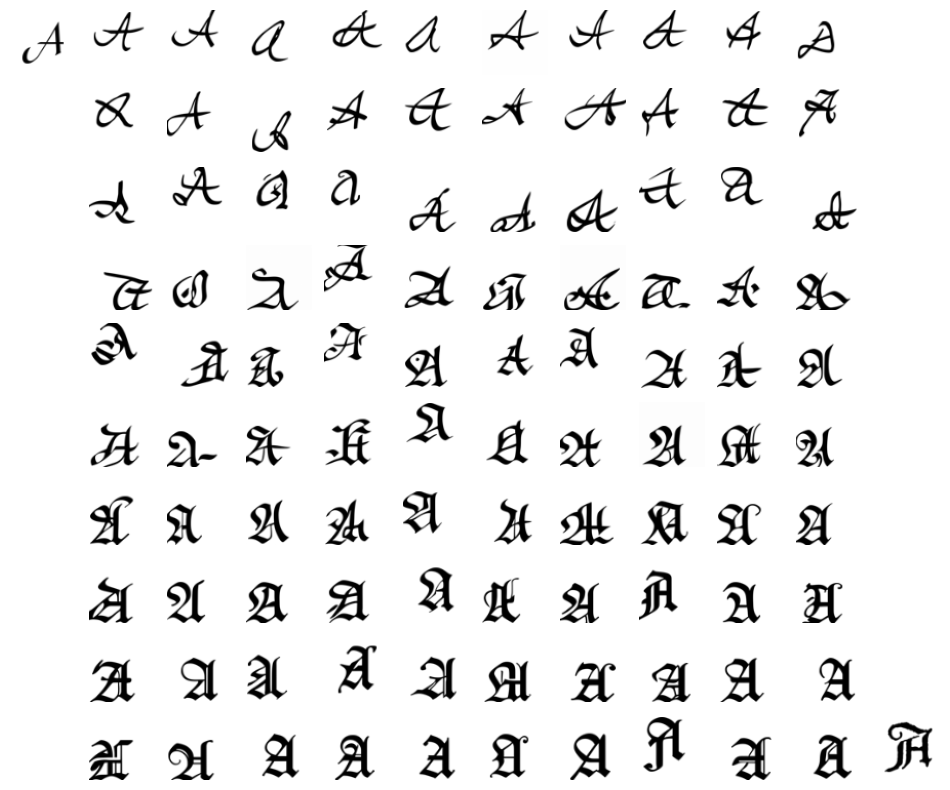

In [40]:
style_scale = 3.
class_scale = 3.
num_split = 100
char = 'A'
interpolation_seed = 3
data_type = 'test' # 'train' or 'val' or 'test'
save_img_parenet_dir = 'result/pick_interpolation/Condition'


# myfonts
# train
# pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198),
#             (284, 494), (710, 494), (693, 769), (275, 185), (284, 249),
#             (91, 406), (80, 471), (2, 3), ]
# pair_id = [(7, 21), (10, 20), (79, 85), (144, 164), (166, 171), (132, 133)]
# pair_id = [(random.randint(0, 13000), random.randint(0, 13000)) for _ in range(10)]
# pair_id = [(56, 184), (77, 222), (460, 461), (24, 40), (521, 550)]


# test
# pair_id = [(50, 81), (703, 727), (909, 918), ]
# pair_id = [(34, 50), (160, 180), (166, 172), (212, 292), (296, 212),
#             (333, 362), (402, 429), (523, 583), (672, 524), (849, 824), ]
# pair_id = [(34, 727), (34, 172), (296, 429), (909, 523) ]
pair_id = [(81, 727), (50, 727), (50, 172), (50, 524), (172, 296), (524, 849)]
pair_id = [(1, 6), (323, 386)]
pair_id = [(166, 950)] # seed=3



# pair_id = [(random.randint(0, 1700), random.randint(0, 1700)) for _ in range(20)]

# google fonts
# pair_id = [(0, 7), (115, 117), (12, 56), (117, 148)]


if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for s1, s2 in pair_id:
    style1_id = s1
    style2_id = s2
    freeze_seed(interpolation_seed)
    print(style1_id, style2_id)

    style_vector1 = data[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style_vector2 = data[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style = torch.cat([(i/(num_split-1))*style_vector1 + (1-i/(num_split-1))*style_vector2 for i in range(num_split)])

    b = style.shape[0]
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for i in range(b)])

    total_timesteps, sampling_timesteps, eta = timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    x_start = None

    with torch.no_grad():
        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            t = torch.full((b,), time, device=device, dtype=torch.long)
            pred_noise = model.forward_with_cond_scale(x, t, classes, style, scale=style_scale)
            x_start  = extract(sqrt_recip_alphas_cumprod, t, x.shape) * x -\
                            extract(sqrt_recipm1_alphas_cumprod, t, x.shape) * pred_noise

            if time_next < 0:
                x = x_start
                continue

            alpha = alphas_cumprod[time]
            alpha_next = alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(x)

            x = x_start * alpha_next.sqrt() + \
                    c * pred_noise + \
                    sigma * noise

    fig, ax = plt.subplots(10, 12, figsize=(12, 10))
    for i in range(b):
        ax[i//10, i%10+1].axis('off')
        ax[i//10, i%10+1].imshow(x[i][0].cpu().detach(), cmap='gray')

    style1_and_style2 = torch.cat([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]]).unsqueeze(1)
    ax[0, 0].imshow(style1_and_style2[1][0].cpu().detach(), cmap='gray')
    ax[9, 11].imshow(style1_and_style2[0][0].cpu().detach(), cmap='gray')

    for i in range(10):
        ax[i, 0].axis('off')
        ax[i, 11].axis('off')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_interpolate_ddim_scale_{class_scale}_{style_scale}_{dataset_name}_{data_type}_char_{char}_style_{style1_id}_{style2_id}.png")
    plt.show()

    # save generated image
    folder_name = f'ddim_{dataset_name}_{data_type}_scale_{class_scale}_{style_scale}_{char}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(model_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = [str(i) + '_' + str(i/(num_split-1)) for i in range(num_split)]
    x_from_0_to_1 = torch.clamp((x.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_generated_image(x_from_0_to_1, save_dir, save_filename)

    # save style1 and style2
    style1_and_style2 = torch.clamp((style1_and_style2.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_style_filename = ['style1', 'style2']
    save_generated_image(style1_and_style2, save_dir, save_style_filename)


## 49分割

1131 352


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

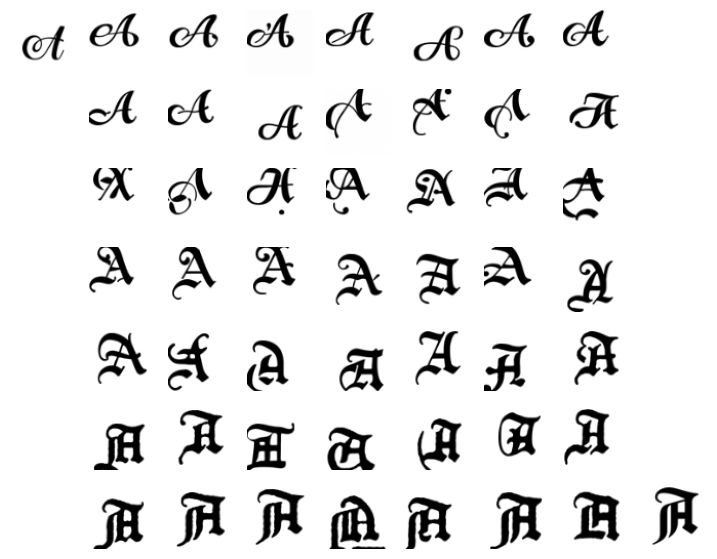

In [18]:
# 49分割 (定性評価のため)
style_scale = 3.
class_scale = 3.
num_split = 49
char = 'A'
interpolation_seed = 2
data_type = 'test' # 'train' or 'val' or 'test'
save_img_parenet_dir = 'result/pick_interpolation/Condition'


# pair_id = [(710, 494)]
# pair_id = [(79, 85)]
# pair_id = [(888, 296)]
pair_id = [(172, 34)]
pair_id = [(309, 1094)]
pair_id = [(722, 1094)]
pair_id = [(212, 830)]
pair_id = [(583, 830)] # seed=3
pair_id = [(1, 499)]
pair_id = [(162, 154), (210, 411), (271, 272), (504, 522), (548, 577), (63, 196)] # serif, san-serif
pair_id = [(166, 830), (830, 948), (830, 50), (32, 40), (32, 830)] # decorative
pair_id = [(352, 357), (830, 352)]
pair_id = [(1131, 352), (35, 352), (1576, 722), (1272, 1000)]
pair_id = [(1013, 352), (0, 659), (1157, 1697), (877, 1194)]
pair_id = [(1598, 352), (333, 352), (384, 352), (50, 352), (727, 352)]
pair_id = [(166, 148)]
# pair_id = [(990, 352)] # seed=3
pair_id = [(575, 994), (542, 1576), (1414, 1466), (601, 696), (1330, 365), (1189, 23), (971, 1120), (1584, 513), (667, 1375), (560, 948)]



if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test

for s1, s2 in pair_id:
    print(s1, s2)
    freeze_seed(interpolation_seed)
    style1_id = s1
    style2_id = s2
    style_vector1 = data[num_class*style1_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style_vector2 = data[num_class*style2_id + (ord(char) - ord('A'))][1].unsqueeze(0).to(device)
    style = torch.cat([(i/(num_split-1))*style_vector1 + (1-i/(num_split-1))*style_vector2 for i in range(num_split)])

    b = style.shape[0]
    classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)
    x = torch.randn(1, 1, image_size, image_size).to(device)
    x = torch.cat([x for i in range(b)])

    total_timesteps, sampling_timesteps, eta = timesteps, 100, 1.

    times = torch.linspace(-1, total_timesteps - 1, steps=sampling_timesteps + 1)   # [-1, 0, 1, 2, ..., T-1] when sampling_timesteps == total_timesteps
    times = list(reversed(times.int().tolist()))
    time_pairs = list(zip(times[:-1], times[1:])) # [(T-1, T-2), (T-2, T-3), ..., (1, 0), (0, -1)]

    x_start = None

    with torch.no_grad():
        for time, time_next in tqdm(time_pairs, desc = 'sampling loop time step'):
            t = torch.full((b,), time, device=device, dtype=torch.long)
            pred_noise = model.forward_with_cond_scale(x, t, classes, style, scale=style_scale)
            x_start  = extract(sqrt_recip_alphas_cumprod, t, x.shape) * x -\
                            extract(sqrt_recipm1_alphas_cumprod, t, x.shape) * pred_noise

            if time_next < 0:
                x = x_start
                continue

            alpha = alphas_cumprod[time]
            alpha_next = alphas_cumprod[time_next]

            sigma = eta * ((1 - alpha / alpha_next) * (1 - alpha_next) / (1 - alpha)).sqrt()
            c = (1 - alpha_next - sigma ** 2).sqrt()

            noise = torch.randn_like(x)

            x = x_start * alpha_next.sqrt() + \
                    c * pred_noise + \
                    sigma * noise

    fig, ax = plt.subplots(7, 9, figsize=(9, 7))
    for i in range(b):
        ax[i//7, i%7+1].axis('off')
        ax[i//7, i%7+1].imshow(x[i][0].cpu().detach(), cmap='gray')

    style1_and_style2 = torch.cat([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]]).unsqueeze(1)
    ax[0, 0].imshow(style1_and_style2[1][0].cpu().detach(), cmap='gray')
    ax[6, 8].imshow(style1_and_style2[0][0].cpu().detach(), cmap='gray')

    for i in range(7):
        ax[i, 0].axis('off')
        ax[i, 8].axis('off')

    plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_emb_qualitative_decorative_{data_type}_style_{style1_id}_{style2_id}.png")
    plt.show()

    # save generated image
    folder_name = f'qualitative_decorative_{data_type}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(model_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = [str(i) + '_' + str(i/(num_split-1)) for i in range(num_split)]
    x_from_0_to_1 = torch.clamp((x.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_generated_image(x_from_0_to_1, save_dir, save_filename)

    # save style1 and style2
    style1_and_style2 = torch.clamp((style1_and_style2.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_style_filename = ['style1', 'style2']
    save_generated_image(style1_and_style2, save_dir, save_style_filename)


# ノイズの局所的重み付け

## 上下

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

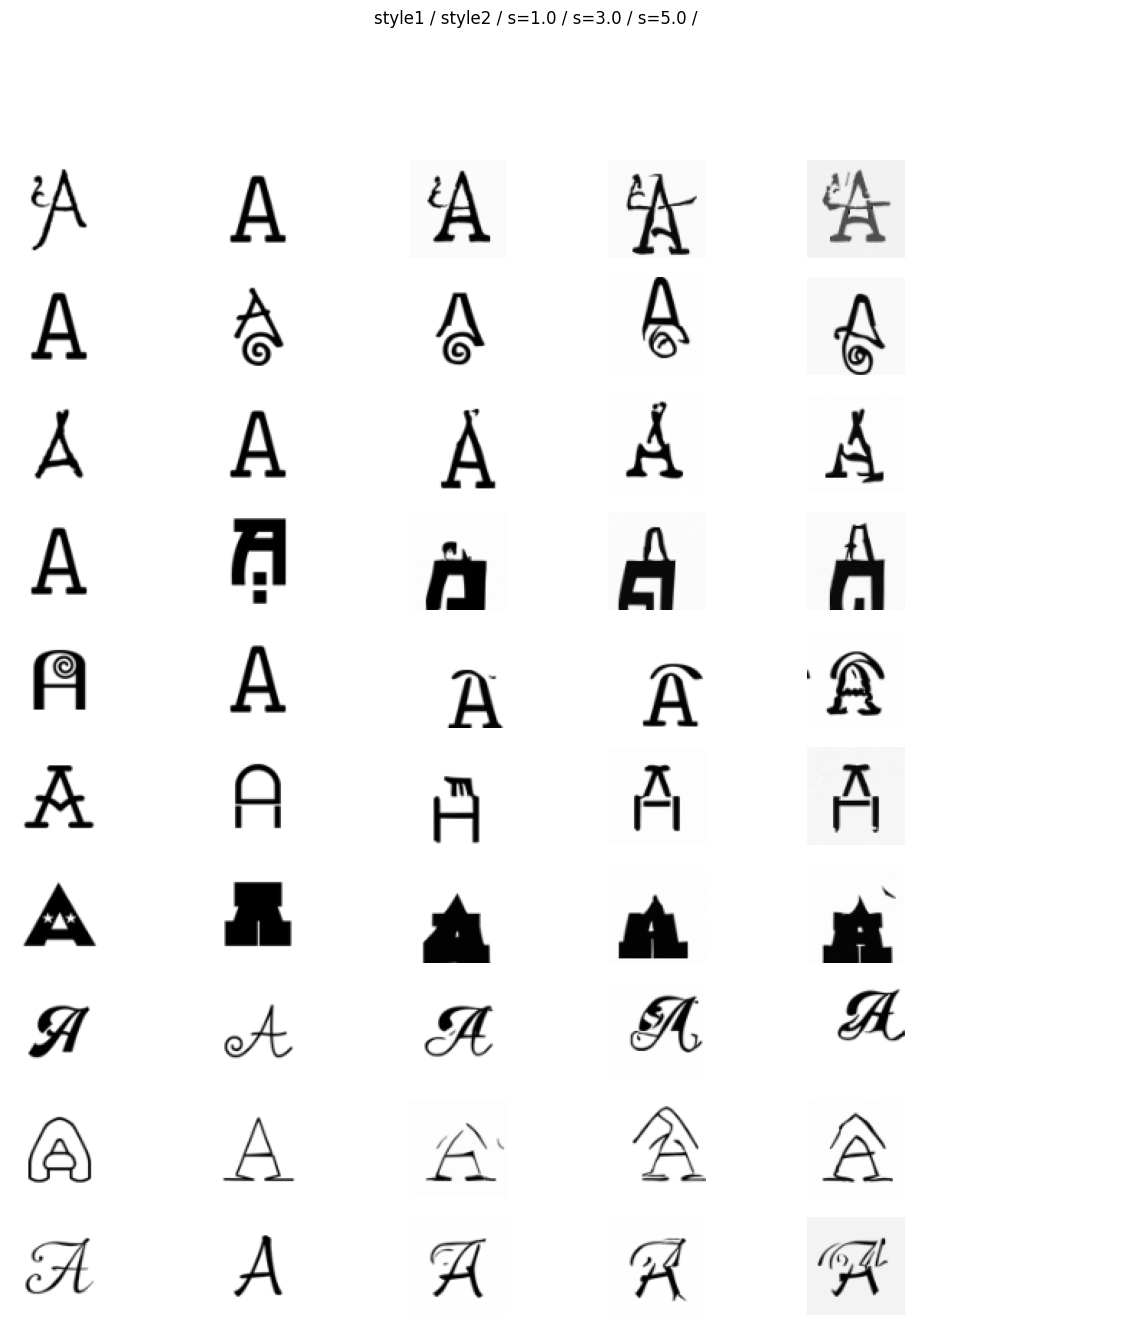

In [ ]:
@torch.no_grad()
def p_sample_noise_local_weighting(model, x, style1, style2, t, scale, s1_mask, s2_mask):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # predict noise
    style1_noise = model.forward_with_cond_scale(x, t, style1, style_scale=scale, rescaled_phi=0.)
    style2_noise = model.forward_with_cond_scale(x, t, style2, style_scale=scale, rescaled_phi=0.)

    # local weighting
    pred_noise = s1_mask * style1_noise + s2_mask * style2_noise

    # sampling
    model_mean = sqrt_recip_alphas_t * (x - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

    if t[0].item() == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# s1が上半分，s2が下半分
pair_id = [(184, 91), (91, 249), (406, 91), (91, 439), (494, 91),
            (471, 80), (4, 261), (222, 275), (265, 256), (460, 491)]
interpolation_seed = 1

freeze_seed(interpolation_seed)

style1_id = torch.tensor([pair_id[i][0] for i in range(len(pair_id))], device=device, dtype=torch.long)
style2_id = torch.tensor([pair_id[i][1] for i in range(len(pair_id))], device=device, dtype=torch.long)
b = min(30, style1_id.size(0))

one_mask = torch.ones(b, 1, image_size//2, image_size)
zero_mask = torch.zeros(b, 1, image_size//2, image_size)
s1_mask = torch.cat([one_mask, zero_mask], dim=2).to(device)
s2_mask = 1. - s1_mask

img = torch.randn((b, channels, image_size, image_size), device=device)
if use_style_encoder == True:
    style1 = torch.cat([d[style1_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
    style2 = torch.cat([d[style2_id[i]][1].unsqueeze(0) for i in range(b)]).to(device)
else:
    style1 = torch.tensor([style1_id[i] for i in range(b)], device=device, dtype=torch.long)
    style2 = torch.tensor([style2_id[i] for i in range(b)], device=device, dtype=torch.long)

img_scale = {a: img for a in [1., 3., 5.]}
for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
    t = torch.full((b,), i, device=device, dtype=torch.long)
    for a in img_scale.keys():
        img_scale[a] = p_sample_noise_local_weighting(model, img_scale[a], style1, style2, t, a, s1_mask, s2_mask)

fig, ax = plt.subplots(10, 6*((b+9)//10), figsize=(15, 15))
for i in range(b):
    for j in range(6):
        ax[i%10, 6*(i//10)+j].axis('off')

    ax[i%10, 6*(i//10)+0].imshow(d[style1_id[i]][0][0], cmap='gray')
    ax[i%10, 6*(i//10)+1].imshow(d[style2_id[i]][0][0], cmap='gray')
    for j, a in enumerate(img_scale.keys()):
        ax[i%10, 6*(i//10)+j+2].imshow(img_scale[a][i][0].cpu().detach().clone(), cmap='gray')

title = 'style1 / style2 / '
for a in img_scale.keys():
    title += f's={a} / '
fig.suptitle(title)
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_local_weighting.png")

## local style awareness

# SDEdit

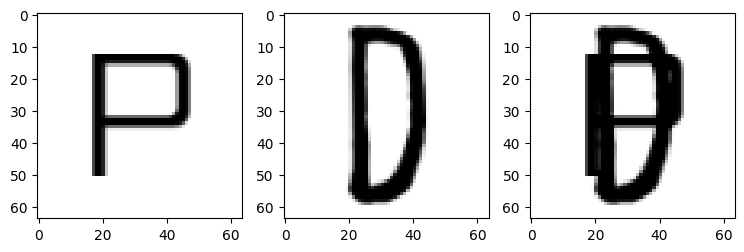

tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000, -0.4572, -0.9983, -1.0000, -0.9579, -0.8672, -1.0000, -1.0000,
        -1.0000, -1.0000,  0.2618,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  0.7901, -0.8731, -1.0000,
        -1.0000, -1.0000, -0.9951, -0.0793,  0.9603,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])


In [5]:
# 画像の足し方を変える
# -1 ~ 1の範囲で足し算すると、黒い部分が薄くなる

img1 = d[275][0]
img2 = d[185][0]
img3 = 2*(1 - torch.clamp(2 - (img1+1)*0.5 - (img2+1)*0.5, min=0., max=1.)) - 1

fig, ax = plt.subplots(1, 3, figsize=(9, 6))
ax[0].imshow(img1[0], cmap='gray')
ax[1].imshow(img2[0], cmap='gray')
ax[2].imshow(img3[0], cmap='gray')
plt.show()

print(img3[0][40])

sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

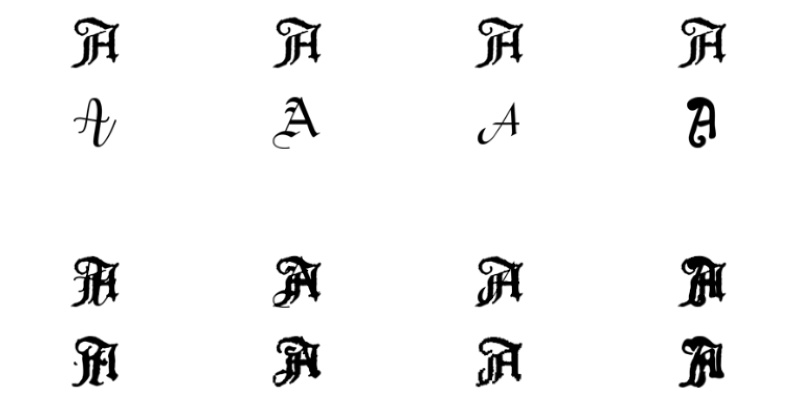

In [7]:
char = 'A'
style1_scale = 0.
style2_scale = 0.
class_scale = 0.
sampling_t = int(0.5 * timesteps)
save_img_parenet_dir = 'result/pick_interpolation/Image'
data_type = 'test' # 'train' or 'val' or 'test

freeze_seed(1)

# myfonts
# pair_id = [(91, 184), (91, 249), (91, 406), (91, 439), (91, 494),]
# pair_id = [(80, 471), (4, 261), (222, 275), (256, 265), (460, 491)]
# pair_id = [(90, 96), (63, 77), (185, 190), (471, 491), (710, 722)]
# pair_id = [(222, 275), (28, 40), (275, 185), (284, 249)]

pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198),]
pair_id = [(284, 249), (284, 494), (710, 494), (693, 769), (275, 185),]
pair_id = [(91, 406), (80, 471), (2, 3), (7, 21), (10, 20), ]
# pair_id = [(random.randint(0, 13000), random.randint(0, 13000)) for _ in range(10)]
pair_id = [(56, 184), (77, 222), (460, 461), (24, 40), (521, 550)]
pair_id = [(79, 85), (144, 164), (166, 171), (132, 133)]

# test
pair_id = [(160, 402), (888, 718), (54, 343), (343, 431)]
pair_id = [(148, 343), (277, 1187), (1128, 1577), (213, 656)]
pair_id = [(448, 1558), (941, 593), (44, 852), (1139, 1315)]
# pair_id = [(402, 1131), (592, 1131), (1131, 1590), (1131, 1068)]
pair_id = [(166, 958), (166, 888), (166, 950), (166, 649)]

# google fonts
# pair_id = [(201, 117), (148, 117), (288, 363), (115, 148), (288, 117), ]


if data_type == 'train':
    data = d
elif data_type == 'val':
    data = d_val
elif data_type == 'test':
    data = d_test


imgs1 = []
imgs2 = []
imgs = []
style1 = []
style2 = []
for s1, s2 in pair_id:
    s1 = num_class*s1 + (ord(char) - ord('A'))
    s2 = num_class*s2 + (ord(char) - ord('A'))
    imgs1.append(data[s1][0])
    imgs2.append(data[s2][0])
    # imgs3.append(data[s3][0])
    # 演算
    # imgs.append(torch.clamp((data[s1][0] - data[s2][0] + data[s3][0]), min=-1, max=1))
    # ORで黒く
    img1 = data[s1][0]
    img2 = data[s2][0]
    img3 = 2*(1 - torch.clamp(2 - (img1+1)*0.5 - (img2+1)*0.5, min=0., max=1.)) - 1
    # ANDのとこを黒く
    # img1 = data[s1][0]
    # img2 = data[s2][0]
    # img3 = ((img1+1)*0.5 + (img2+1)*0.5) - 1
    # ２値化
    # img1 = torch.where(data[s1][0]>0, torch.tensor(1.), torch.tensor(0))
    # img2 = torch.where(data[s2][0]>0, torch.tensor(1.), torch.tensor(0))
    # img3 = 2 * (1 - torch.clamp(2 - (img1 + img2), min=0., max=1.)) - 1
    imgs.append(img3)

    # style.append(F.normalize(data[s1][1] - data[s2][1] + data[s3][1], dim=0))
    style1.append(data[s1][1])
    style2.append(data[s2][1])
    # style.append(F.normalize(data[s1][1] + data[s2][1], dim=0))
    # style.append((data[s1][1] + data[s2][1])/2.)

imgs = torch.stack(imgs).to(device)
style1 = torch.stack(style1).to(device)
style2 = torch.stack(style2).to(device)

b = imgs.shape[0]
t = torch.full((b,), sampling_t-1, device=device, dtype=torch.long)
classes = torch.tensor([ord(char) - ord('A') for _ in range(b)], device=device, dtype=torch.long)

noisy_imgs = q_sample(imgs, t)

out = noisy_imgs
with torch.no_grad():
    for i in tqdm(reversed(range(0, sampling_t)), desc='sampling loop time step', total=sampling_t):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        betas_t = extract(betas, t, out.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, out.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, out.shape)

        nocond_noise = model(out, t, classes, style1, class_drop_prob=1., style_drop_prob=1.)
        pred_noise = nocond_noise.clone()

        if class_scale > 0.:
            pred_noise += class_scale  * (model(out, t, classes, style1, class_drop_prob=0., style_drop_prob=1.) - nocond_noise)
        if style1_scale > 0.:
            pred_noise += style1_scale * (model(out, t, classes, style1, class_drop_prob=1., style_drop_prob=0.) - nocond_noise)
        if style2_scale > 0.:
            pred_noise += style2_scale * (model(out, t, classes, style2, class_drop_prob=1., style_drop_prob=0.) - nocond_noise)

        model_mean = sqrt_recip_alphas_t * (out - betas_t * pred_noise / sqrt_one_minus_alphas_cumprod_t)

        if i == 0:
            out = model_mean
        else:
            posterior_variance_t = extract(posterior_variance, t, out.shape)
            _noise = torch.randn_like(out)
            out = model_mean + torch.sqrt(posterior_variance_t) * _noise

fig, ax = plt.subplots(5, b, figsize=(10, 5))
for i in range(imgs.shape[0]):
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
    ax[3, i].axis('off')
    ax[4, i].axis('off')
    ax[0, i].imshow(imgs1[i][0].cpu().detach(), cmap='gray')
    ax[1, i].imshow(imgs2[i][0].cpu().detach(), cmap='gray')
    # ax[2, i].imshow(imgs3[i][0].cpu().detach(), cmap='gray')
    ax[3, i].imshow(imgs[i][0].cpu().detach(), cmap='gray')
    ax[4, i].imshow(out[i][0].cpu().detach(), cmap='gray')

plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_SDEdit_interpolate_t_{sampling_t}_scale_{class_scale}_{style1_scale}_{style2_scale}_{dataset_name}_{data_type}_{char}_id_{int(time.time())}.png")
plt.show()

for i in range(b):
    # save generated image
    style1_id, style2_id = pair_id[i]
    folder_name = f'{dataset_name}_{data_type}_t_{sampling_t}_scale_{class_scale}_{style1_scale}_{style2_scale}_{char}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(model_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = ['generated']
    out_from_0_to_1 = torch.clamp((out[i].cpu().detach().clone()+1)*0.5, min=0., max=1.).unsqueeze(0)
    save_generated_image(out_from_0_to_1, save_dir, save_filename)

    # save style1 and style2
    style1_and_style2 = torch.cat([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]]).unsqueeze(1)
    style1_and_style2 = torch.clamp((style1_and_style2.cpu().detach().clone()+1)*0.5, min=0., max=1.)
    save_style_filename = ['style1', 'style2']
    save_generated_image(style1_and_style2, save_dir, save_style_filename)

# スタイルベクトルと推定ノイズの関係

## PCA

[0.80927855 0.14274637 0.03308946]


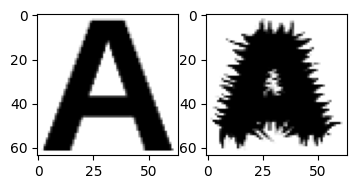

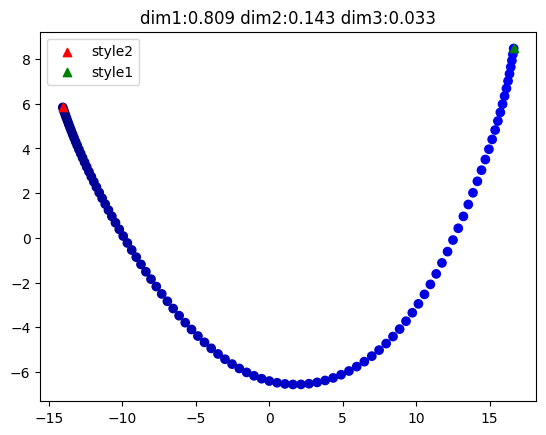

In [ ]:
style1_id = 11
style2_id = 12
num_dim = 64*64
num_split = 100
visualize_t = 500 # from 0 to timesteps-1

style_vector1 = d[style1_id][1].unsqueeze(0).to(device)
style_vector2 = d[style2_id][1].unsqueeze(0).to(device)
style = torch.cat([(i/num_split)*style_vector1 + (1-i/num_split)*style_vector2 for i in range(num_split+1)])
# style = torch.cat([(torch.sin(torch.tensor(i/num_split*torch.math.pi/2)))*style_vector1 + (torch.cos(torch.tensor((i/num_split)*torch.math.pi/2)))*style_vector2 for i in range(num_split+1)])
b = style.shape[0]
x = torch.randn(1, 1, image_size, image_size).to(device)
x = torch.cat([x for i in range(b)])

with torch.no_grad():
    for t_index in reversed(range(0, timesteps)):
        t = torch.full((b,), t_index, device=device, dtype=torch.long)
        betas_t = extract(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

        noise = model(x, t, style, style_drop_prob=0.)
        model_mean = sqrt_recip_alphas_t * (x - betas_t * noise / sqrt_one_minus_alphas_cumprod_t)

        if t_index == 0:
            x = model_mean
        else:
            posterior_variance_t = extract(posterior_variance, t, x.shape)
            _noise = torch.randn_like(x)
            x = model_mean + torch.sqrt(posterior_variance_t) * _noise

        x = torch.cat([x[0] for i in range(b)]).unsqueeze(1)

        if t_index == visualize_t:
            predicted_noise = noise.cpu().detach().numpy().reshape(b, -1)
            break

# show style1 and style2
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(d[style1_id][0][0], cmap='gray')
ax[1].imshow(d[style2_id][0][0], cmap='gray')

# pca
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(predicted_noise)
print(pca.explained_variance_ratio_)

# 2次元plot
color = [(0, 0, 0.5 + 0.5*i/num_split) for i in range(num_split+1)]
fig, ax = plt.subplots(1, 1)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=color)
ax.scatter(X_reduced[0, 0], X_reduced[0, 1], c='red', marker='^', label='style2')
ax.scatter(X_reduced[-1, 0], X_reduced[-1, 1], c='green', marker='^', label='style1')
ax.set_title(f'dim1:{pca.explained_variance_ratio_[0]:.3f} dim2:{pca.explained_variance_ratio_[1]:.3f} dim3:{pca.explained_variance_ratio_[2]:.3f}')
plt.legend()
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_variation_pca_2d_t_{visualize_t}_style_{style1_id}_{style2_id}.png")
plt.show()

# # 3次元plot
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c='blue', marker='o', label='Data Points')
# ax.scatter(X_reduced[0, 0], X_reduced[0, 1], X_reduced[0, 2], c='red', marker='^', label='style2')
# ax.scatter(X_reduced[-1, 0], X_reduced[-1, 1], X_reduced[-1, 2], c='green', marker='^', label='style1')
# ax.set_xlabel('Dimension 1')
# ax.set_ylabel('Dimension 2')
# ax.set_zlabel('Dimension 3')
# ax.set_title(f'dim1:{pca.explained_variance_ratio_[0]:.3f} dim2:{pca.explained_variance_ratio_[1]:.3f} dim3:{pca.explained_variance_ratio_[2]:.3f}')
# # # 超平面
# # normal_vector = np.cross(X_reduced[0], X_reduced[-1])
# # xx, yy = np.meshgrid(range(-3, 4), range(-3, 4))
# # xx = xx / 10.
# # yy = yy / 10.
# # zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2]
# # ax.plot_surface(xx, yy, zz, alpha=0.5, color='red', label='Hyperplane')
# plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_variation_pca_3d_t_{visualize_t}_style{style1_id}_{style2_id}.png")
# plt.show()

## ノルムと角度

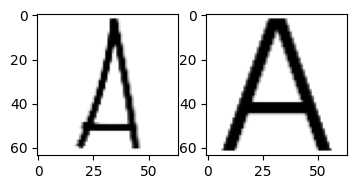

<Figure size 1000x600 with 0 Axes>

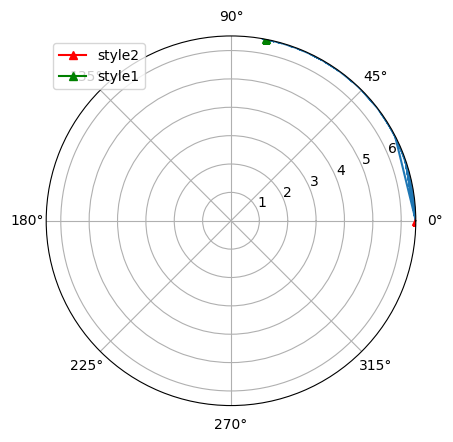

In [ ]:
style1_id = 1
style2_id = 60
num_dim = 64*64
num_split = 100
visualize_t = 999 # from 0 to timesteps-1

style_vector1 = d[style1_id][1].unsqueeze(0).to(device)
style_vector2 = d[style2_id][1].unsqueeze(0).to(device)
style = torch.cat([(i/num_split)*style_vector1 + (1-i/num_split)*style_vector2 for i in range(num_split+1)])
b = style.shape[0]
x = torch.randn(1, 1, image_size, image_size).to(device)
x = torch.cat([x for i in range(b)])

with torch.no_grad():
    for t_index in reversed(range(0, timesteps)):
        t = torch.full((b,), t_index, device=device, dtype=torch.long)
        betas_t = extract(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

        noise = model(x, t, style, style_drop_prob=0.)
        model_mean = sqrt_recip_alphas_t * (x - betas_t * noise / sqrt_one_minus_alphas_cumprod_t)

        if t_index == 0:
            x = model_mean
        else:
            posterior_variance_t = extract(posterior_variance, t, x.shape)
            _noise = torch.randn_like(x)
            x = model_mean + torch.sqrt(posterior_variance_t) * _noise

        x = torch.cat([x[0] for i in range(b)]).unsqueeze(1)

        if t_index == visualize_t:
            predicted_noise = noise.cpu().detach().numpy().reshape(b, -1)
            break

# 各データ点とベクトルaのなす角度を計算
cos_sim = np.dot(predicted_noise, predicted_noise[0])\
            / (np.linalg.norm(predicted_noise, axis=1) * np.linalg.norm(predicted_noise[0]))
angles = np.arccos(np.clip(cos_sim, -1.0, 1.0))

# 各データ点のノルムを計算
norms = np.linalg.norm(predicted_noise, axis=1)

# show style1 and style2
fig, ax = plt.subplots(1, 2, figsize=(4, 2))
ax[0].imshow(d[style1_id][0][0], cmap='gray')
ax[1].imshow(d[style2_id][0][0], cmap='gray')
plt.show()

# 散布図の作成
color = [(0, 0, 0.5 + 0.5*i/num_split) for i in range(num_split+1)]
fig = plt.figure(figsize=(10, 6))
plt.figure()
plt.scatter(angles, norms, color=color)
plt.scatter(angles[0], norms[0], c='red', marker='^', label='style2')
plt.scatter(angles[-1], norms[-1], c='green', marker='^', label='style1')
# rate = 1.4/angles.max()
# plt.polar(angles*rate, norms)
# plt.polar(angles[0]*rate, norms[0], c='red', marker='^', label='style2')
# plt.polar(angles[-1]*rate, norms[-1], c='green', marker='^', label='style1')
plt.legend()
plt.savefig(f"result/{os.path.basename(model_path).split('.')[0]}_noise_variation_polar_t_{visualize_t}_style_{style1_id}_{style2_id}.png")
plt.show()


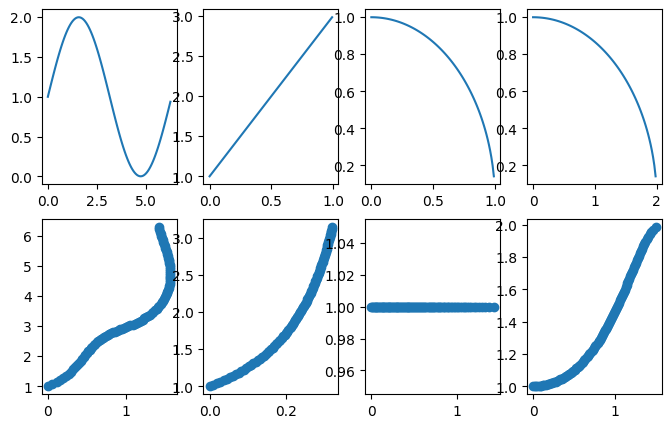

In [ ]:
num_split = 100
fig, ax = plt.subplots(2, 4, figsize=(8, 5))

for i in range(4):
    if i == 0:
        # sin
        x = np.arange(0, 2*np.pi, 2*np.pi/num_split)
        y = np.sin(x) + 1

    elif i == 1:
        # 直線
        x = np.arange(0, 1, 1/num_split)
        y = 2*x + 1

    elif i == 2:
        # 円
        x = np.arange(0, 1, 1/num_split)
        y = np.sqrt(1 - x**2)
    elif i == 3:
        # 楕円
        x = np.arange(0, 2, 2/num_split)
        y = np.sqrt(1 - (x**2)/4)

    xy = np.stack([x, y]).T
    cos_sim = np.dot(xy, xy[0]) / (np.linalg.norm(xy, axis=1) * np.linalg.norm(xy[0]))
    angles = np.arccos(np.clip(cos_sim, -1.0, 1.0))
    norms = np.linalg.norm(xy, axis=1)
    ax[0, i].plot(x, y)
    # ax[1, i].polar(angles, norms)
    ax[1, i].scatter(angles, norms)

plt.show()


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3次元データを生成
num_points = 100
dim = 3
a = torch.randn(dim)
b = torch.randn(dim)

data = []
for i in range(num_points + 1):
    alpha = i / num_points
    data.append((alpha * a + (1 - alpha) * b).numpy())

data = np.array(data)

# プロット
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='blue', marker='o', label='Data Points')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('Visualization of Hyperplane in 3D Space')

# 超平面を可視化
normal_vector = np.cross(a.numpy(), b.numpy())
xx, yy = np.meshgrid(range(-3, 4), range(-3, 4))
zz = (-normal_vector[0] * xx - normal_vector[1] * yy) / normal_vector[2]
ax.plot_surface(xx, yy, zz, alpha=0.5, color='red', label='Hyperplane')

plt.show()


# 文字認識モデルの性能評価

In [7]:
# build model
classifier = models.resnet18()
# classifier = models.resnet50()
classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
classifier.fc = nn.Linear(classifier.fc.in_features, num_class)

# load weight
classifier.to(device)
classifier.load_state_dict(torch.load('weight/char_classifier2.pth', map_location=device))
# classifier.load_state_dict(torch.load('weight/char_classifier.pth', map_location=device))
classifier.eval()

for data_type in ['train', 'val', 'test']:
    correct = 0
    for img, _, label in dataloader[data_type]:
        with torch.no_grad():
            img = img.to(device)
            o = classifier((img+1)*0.5).cpu().detach() # 0-1input
            pred = torch.argmax(o, dim=1)
            correct += torch.sum(pred == label.data)

    acc = correct.double() / len(dataloader[data_type].dataset)
    print(f'{data_type} accuracy: {acc:.3f}')

train accuracy: 0.974
val accuracy: 0.920
test accuracy: 0.916


# weightが違うフォントのcsv作り

In [ ]:
df = pd.read_csv('csv_files/google_fonts_drop_none.csv')
output_dict = {'style1': [], 'style2': [], 'data_type': [],}

# 189
# serif 42
# sans-serif 122
# display 19
# handwriting 6
# Light 141 - Regular 866 - Bold 268
# LightItalic 54 - Italic 131 - BoldItalic 95
# small = 'Light'
# medium = 'Regular'
# large = 'Bold'

# 134
# serif 28
# sans-serif 99
# display 5
# handwriting 2
# Light 141 - Medium 121 - Bold 268
# LightItalic 54 - MediumItalic 44 - BoldItalic 95
small = 'Light'
medium = 'Medium'
large = 'Bold'

path_list = []
for data_type in ['train', 'valid', 'test']:
    data_type_df = df[df['data_type'] == data_type].reset_index(drop=True)

    for _, row in data_type_df.iterrows():
        font = row['font']
        category = row['category']

        if small not in font:
            continue
        if os.path.exists('../font2img/image/' + font) == False:
            continue

        medium_font = font.replace(small, medium)
        large_font = font.replace(small, large)

        if medium == 'Regular' and 'Italic' in font:
            medium_font = font.replace(small, '') # LightItalic -> Italic

        if os.path.exists('../font2img/image/' + medium_font) == False or os.path.exists('../font2img/image/' + large_font) == False:
            continue

        path_list.append({small: font, medium: medium_font, large: large_font, 'category': category})

print(len(path_list))

output_filename = 'csv_files/weight_interpolation.csv'
output_df = pd.DataFrame(path_list)
output_df.to_csv(output_filename, index=False)

# font pairのcsv作り

In [6]:
# SANS_SERIF 1265
# SERIF 623
# DISPLAY 455
# HANDWRITING 202


MAX_PAIR_CNT = 100
category_list = ['SANS_SERIF', 'SERIF', 'DISPLAY', 'HANDWRITING']


df = pd.read_csv('csv_files/google_fonts_drop_none.csv')
font_list = {c: [] for c in category_list}
for cate in category_list:
    data_type_df = df[df['category'] == cate].reset_index(drop=True)

    for _, row in data_type_df.iterrows():
        font = row['font']

        if os.path.exists('../font2img/image/' + font) == False:
            continue

        font_list[cate].append(font)

for c, p in font_list.items():
    print(c, len(p))

output_dict = {'style1': [], 'style2': [], 'category': [],}
for cate in category_list:
    pair_font_list = list(combinations(font_list[cate], 2))
    random.shuffle(pair_font_list)
    pair_font_list = pair_font_list[:MAX_PAIR_CNT]

    output_dict['style1'].extend([p[0] for p in pair_font_list])
    output_dict['style2'].extend([p[1] for p in pair_font_list])
    output_dict['category'].extend([cate for _ in range(len(pair_font_list))])

# output_filename = 'csv_files/letter_recognition.csv'
# output_df = pd.DataFrame(output_dict)
# output_df.to_csv(output_filename, index=False)

SANS_SERIF 1265
SERIF 623
DISPLAY 455
HANDWRITING 202


In [11]:
MAX_PAIR_CNT = 100
category_list = ['RANDOM']

df = pd.read_csv('csv_files/google_fonts_drop_none.csv')
font_list = []
for _, row in df.iterrows():
    font = row['font']

    if os.path.exists('../font2img/image/' + font) == False:
        continue

    font_list.append(font)


print(len(font_list))

output_dict = {'style1': [], 'style2': [], 'category': [],}
for cate in category_list:
    pair_font_list = list(combinations(font_list, 2))
    random.shuffle(pair_font_list)
    pair_font_list = pair_font_list[:MAX_PAIR_CNT]

    output_dict['style1'].extend([p[0] for p in pair_font_list])
    output_dict['style2'].extend([p[1] for p in pair_font_list])
    output_dict['category'].extend([cate for _ in range(len(pair_font_list))])

output_filename = 'csv_files/letter_recognition_random.csv'
output_df = pd.DataFrame(output_dict)
output_df.to_csv(output_filename, index=False)

2545


In [6]:
# myfonts
MAX_PAIR_CNT = 500
path_list = glob.glob(f'../font2img/myfonts/test/*')

output_dict = {'style1': [], 'style2': []}

pair_font_list = list(combinations(path_list, 2))
freeze_seed(1)
random.shuffle(pair_font_list)
pair_font_list = pair_font_list[:MAX_PAIR_CNT]

output_dict['style1'] = [os.path.basename(p[0]) for p in pair_font_list]
output_dict['style2'] = [os.path.basename(p[1]) for p in pair_font_list]

output_filename = 'csv_files/letter_recognition_myfonts.csv'
output_df = pd.DataFrame(output_dict)
output_df.to_csv(output_filename, index=False)

In [13]:
iamge_size = 64
margin = 5

df = pd.read_csv('csv_files/letter_recognition_myfonts.csv')

data_list = []
for _, row in df.iterrows():
    style1_imgs = np.load(f"../font2img/myfonts/test/{row['style1']}")['arr_0']
    style2_imgs = np.load(f"../font2img/myfonts/test/{row['style2']}")['arr_0']
    for label in range(num_class):
        style1_img = style1_imgs[label]
        style2_img = style2_imgs[label]
        style1_img = torch.tensor(preprocessing_myfonts(style1_img, image_size, margin))
        style2_img = torch.tensor(preprocessing_myfonts(style2_img, image_size, margin))

        data_list.append({'style1': style1_img, 'style2': style2_img,\
                        'style1_name': row['style1'].split('.')[0], 'style2_name': row['style2'].split('.')[0],\
                        'label': label})



print(f'SIZE: {len(data_list)}')

SIZE: 13000


# 定量評価

## weight interpolation

In [13]:
# weight interpolation

# FANnet SERIF: 0.0905099709802519,  size: 713
# FANnet SANS_SERIF: 0.08566615072482806,  size: 2560
# FANnet DISPLAY: 0.11037967479501577,  size: 129
# FANnet HANDWRITING: 0.10990516350093255,  size: 52

post_transform = Compose([
                        transforms.ToTensor(),
                        ])

category_list = ['SERIF', 'SANS_SERIF', 'HANDWRITING', 'DISPLAY']
not_eval_font = []
not_eval_csv_path = 'csv_files/weight_not_eval_font.csv'
df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_font_char'].to_list())

ave = 0.
total_size = 0
for cate in category_list:
    path_list = glob.glob(f'result/weight_interpolation/FANnet/{cate}/*.png')
    imgs = []
    gt_imgs = []
    for img_path in path_list:
        fontname = os.path.basename(img_path).split('_')[0]
        char = os.path.basename(img_path).split('_')[1][0]
        img = cv2.imread(img_path, 0)
        gt = cv2.imread(f'../font2img/image/{fontname}/{char}.png', 0)
        if f'{cate}_{fontname}_{char}' in not_eval_font:
            img = post_transform(img)
        else:
            try:
                img = post_transform(postprocessing(img, img_size=64, margin=0))
            except:
                print(img_path)
                pass

        imgs.append(img)
        gt_imgs.append(post_transform(postprocessing(gt, img_size=64, margin=0)))

    criterion = nn.MSELoss()
    loss = 0.

    for im, gt in zip(imgs, gt_imgs):
        loss += criterion(im, gt).item()
    ave += loss
    total_size += len(imgs)
    loss /= len(imgs)

    print(f'FANnet {cate}: {loss},  size: {len(imgs)}')

ave /= total_size
print(f'FANnet ave: {ave},  size: {total_size}')

FANnet SERIF: 0.11303370697007603,  size: 728


FANnet SANS_SERIF: 0.1086733724582267,  size: 2574
FANnet DISPLAY: 0.13605700816831615,  size: 130
FANnet HANDWRITING: 0.1338782677283654,  size: 52
FANnet ave: 0.11098245705093197,  size: 3484


In [14]:
"""バグ修正後
FANnet SERIF: 0.11265052485098177,  size: 713
FANnet SANS_SERIF: 0.10847892761230468,  size: 2560
FANnet DISPLAY: 0.13517631116763565,  size: 129
FANnet HANDWRITING: 0.1338782677283654,  size: 52
FANnet ave: 0.11071954052366821,  size: 3454

Image SERIF: 0.10467058478699158,  size: 713
Image SANS_SERIF: 0.11580677032470703,  size: 2560
Image DISPLAY: 0.14944812863372092,  size: 129
Image HANDWRITING: 0.12337083082932693,  size: 52
Image ave: 0.11487827179538217,  size: 3454

Condition SERIF: 0.12461410030241936,  size: 713
Condition SANS_SERIF: 0.1277740478515625,  size: 2560
Condition DISPLAY: 0.16625030281007752,  size: 129
Condition HANDWRITING: 0.16110933743990385,  size: 52
Condition ave: 0.1290606226476549,  size: 3454

Noise SERIF: 0.1360753555618864,  size: 713
Noise SANS_SERIF: 0.1378911018371582,  size: 2560
Noise DISPLAY: 0.1736256207606589,  size: 129
Noise HANDWRITING: 0.17909123347355768,  size: 52
Noise ave: 0.1394711634156051,  size: 3454
"""

"""除外なし
FANnet SERIF: 0.11303370697007603,  size: 728
FANnet SANS_SERIF: 0.1086733724582267,  size: 2574
FANnet HANDWRITING: 0.1338782677283654,  size: 52
FANnet DISPLAY: 0.13605700816831615,  size: 130
FANnet ave: 0.11098245705093197,  size: 3484

Image SERIF: 0.10552386641378184,  size: 728
Image SANS_SERIF: 0.11595089216379581,  size: 2574
Image HANDWRITING: 0.12337083082932693,  size: 52
Image DISPLAY: 0.15049004187964415,  size: 130
Image ave: 0.11517163026013844,  size: 3484

Condition SERIF: 0.12489810831021245,  size: 728
Condition SANS_SERIF: 0.12777972264938947,  size: 2574
Condition HANDWRITING: 0.16110933743990385,  size: 52
Condition DISPLAY: 0.16736027993635216,  size: 130
Condition ave: 0.12915193768311248,  size: 3484

Noise SERIF: 0.13618957662516487,  size: 728
Noise SANS_SERIF: 0.1378567312185838,  size: 2574
Noise HANDWRITING: 0.17909123347355768,  size: 52
Noise DISPLAY: 0.17458076607549727,  size: 130
Noise ave: 0.13949411069752995,  size: 3484
"""



category_list = ['SERIF', 'SANS_SERIF', 'HANDWRITING', 'DISPLAY']
not_eval_csv_path = 'csv_files/weight_not_eval_font.csv'
approach_list = ['Noise', 'Condition', 'Image']

post_transform = Compose([
                        transforms.ToTensor(),
                        ])
df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_font_char'].to_list())

for approach in approach_list:
    print()
    ave = 0.
    total_size = 0
    for cate in category_list:
        path_list = glob.glob(f'result/weight_interpolation/log39_fannet_retrain_step_final/{approach}/{cate}/*.png')
        imgs = []
        gt_imgs = []
        for img_path in path_list:
            fontname = os.path.basename(img_path).split('_')[0]
            char = os.path.basename(img_path).split('_')[1][0]
            img = cv2.imread(img_path, 0)
            gt = cv2.imread(f'../font2img/image/{fontname}/{char}.png', 0)
            if f'{cate}_{fontname}_{char}' in not_eval_font:
                img = post_transform(img)

            else:
                try:
                    img = post_transform(postprocessing(img, img_size=64, margin=0))

                except:
                    print(img_path)

            imgs.append(img)
            gt_imgs.append(post_transform(postprocessing(gt, img_size=64, margin=0)))


        criterion = nn.MSELoss()
        loss = 0.

        for im, gt in zip(imgs, gt_imgs):
            loss += criterion(im, gt).item()
        ave += loss
        total_size += len(imgs)
        loss /= len(imgs)

        print(f'{approach} {cate}: {loss},  size: {len(imgs)}')

    ave /= total_size
    print(f'{approach} ave: {ave},  size: {total_size}')


Noise SERIF: 0.13618957662516487,  size: 728
Noise SANS_SERIF: 0.1378567312185838,  size: 2574
Noise HANDWRITING: 0.17909123347355768,  size: 52
Noise DISPLAY: 0.17458076607549727,  size: 130
Noise ave: 0.13949411069752995,  size: 3484

Condition SERIF: 0.12489810831021245,  size: 728
Condition SANS_SERIF: 0.12777972264938947,  size: 2574
Condition HANDWRITING: 0.16110933743990385,  size: 52
Condition DISPLAY: 0.16736027993635216,  size: 130
Condition ave: 0.12915193768311248,  size: 3484

Image SERIF: 0.10552386641378184,  size: 728
Image SANS_SERIF: 0.11595089216379581,  size: 2574
Image HANDWRITING: 0.12337083082932693,  size: 52
Image DISPLAY: 0.15049004187964415,  size: 130
Image ave: 0.11517163026013844,  size: 3484


## letter recognition

In [5]:
# letter recognition
"""
margin = 5
FANnet SERIF: 0.9340181746345319,  size: 2531
FANnet SANS_SERIF: 0.9241160111243544,  size: 2517
FANnet DISPLAY: 0.9292490118577075,  size: 2530
FANnet HANDWRITING: 0.7775467775467776,  size: 1924

margin = 10
FANnet SERIF: 0.949032003160806,  size: 2531
FANnet SANS_SERIF: 0.929678188319428,  size: 2517
FANnet DISPLAY: 0.9466403162055336,  size: 2530
FANnet HANDWRITING: 0.7962577962577962,  size: 1924

margin = 15
FANnet SERIF: 0.9320426708810746,  size: 2531
FANnet SANS_SERIF: 0.9201430274135876,  size: 2517
FANnet DISPLAY: 0.9335968379446641,  size: 2530
FANnet HANDWRITING: 0.7863825363825364,  size: 1924

margin = 20
FANnet SERIF: 0.916633741604109,  size: 2531
FANnet SANS_SERIF: 0.8935240365514502,  size: 2517
FANnet DISPLAY: 0.9114624505928853,  size: 2530
FANnet HANDWRITING: 0.7546777546777547,  size: 1924
"""

post_transform = Compose([
                        transforms.ToTensor(),
                        ])

category_list = ['SERIF', 'SANS_SERIF', 'DISPLAY', 'HANDWRITING', 'RANDOM']
not_eval_font = []
not_eval_csv_path = 'csv_files/recognition_not_eval_font.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier_path = './weight/char_classifier2.pth'

classifier = models.resnet18()
classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
classifier.fc = nn.Linear(classifier.fc.in_features, 26)
classifier.to(device)
classifier.load_state_dict(torch.load(classifier_path, map_location=device))
classifier.eval()

df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_original-font'].to_list())

ave = 0.
total_size = 0
for cate in category_list:
    path_list = glob.glob(f'result/letter_recognition/FANnet/{cate}/*.png')
    imgs = []
    labels = []
    for img_path in path_list:
        original_font = os.path.basename(img_path).split('_pred')[0]
        label = ord(original_font[-1]) - ord('A')
        img = cv2.imread(img_path, 0)
        if f'{cate}_{original_font}' in not_eval_font:
            img = post_transform(img)
        else:
            try:
                margin = 10
                img = post_transform(postprocessing(img, img_size=64, margin=margin))
            except:
                print(f'{cate}_{original_font},FANnet')

        imgs.append(img)
        labels.append(label)

    imgs = torch.stack(imgs).float()
    labels = torch.tensor(labels)

    acc = 0.

    batch_size = 256
    for i in range(0, len(imgs), batch_size):
        img = imgs[i:i+batch_size].to(device)
        out = classifier(img)
        pred = torch.argmax(out, dim=1).cpu().detach().clone()
        acc += torch.sum(pred == labels[i:i+batch_size]).item()
    ave += acc
    total_size += len(imgs)
    acc /= len(imgs)

    print(f'FANnet {cate}: {acc},  size: {len(imgs)}')

ave /= total_size
print(f'FANnet ave: {ave},  size: {total_size}')

FANnet SERIF: 0.9288461538461539,  size: 2600
FANnet SANS_SERIF: 0.9080769230769231,  size: 2600
FANnet DISPLAY: 0.9311538461538461,  size: 2600
FANnet HANDWRITING: 0.6319230769230769,  size: 2600
FANnet RANDOM: 0.943076923076923,  size: 2600
FANnet ave: 0.8686153846153846,  size: 13000


In [6]:
"""バグ修正後
FANnet SERIF: 0.9478467009087317,  size: 2531
FANnet SANS_SERIF: 0.931062124248497,  size: 2495
FANnet HANDWRITING: 0.803014553014553,  size: 1924
FANnet DISPLAY: 0.952079207920792,  size: 2525
FANnet RANDOM: 0.9581193204267088,  size: 2531
FANnet ave: 0.9242045643844744,  size: 12006

Image SERIF: 0.9893322797313315,  size: 2531
Image SANS_SERIF: 0.9939879759519038,  size: 2495
Image HANDWRITING: 0.8633056133056133,  size: 1924
Image DISPLAY: 0.9184158415841585,  size: 2525
Image RANDOM: 0.9640458316870802,  size: 2531
Image ave: 0.9498584041312677,  size: 12006

Condition SERIF: 0.9913077834847887,  size: 2531
Condition SANS_SERIF: 0.988376753507014,  size: 2495
Condition HANDWRITING: 0.9386694386694386,  size: 1924
Condition DISPLAY: 0.9386138613861386,  size: 2525
Condition RANDOM: 0.9723429474516001,  size: 2531
Condition ave: 0.9671830751291021,  size: 12006

Noise SERIF: 0.9770841564598973,  size: 2531
Noise SANS_SERIF: 0.9807615230460922,  size: 2495
Noise HANDWRITING: 0.9012474012474012,  size: 1924
Noise DISPLAY: 0.9374257425742575,  size: 2525
Noise RANDOM: 0.9569340181746345,  size: 2531
Noise ave: 0.9531067799433617,  size: 12006
"""


"""除外なし
FANnet SERIF: 0.9288461538461539,  size: 2600
FANnet SANS_SERIF: 0.9080769230769231,  size: 2600
FANnet HANDWRITING: 0.6319230769230769,  size: 2600
FANnet DISPLAY: 0.9311538461538461,  size: 2600
FANnet RANDOM: 0.943076923076923,  size: 2600
FANnet ave: 0.8686153846153846,  size: 13000

Image SERIF: 0.9892307692307692,  size: 2600
Image SANS_SERIF: 0.9938461538461538,  size: 2600
Image HANDWRITING: 0.8465384615384616,  size: 2600
Image DISPLAY: 0.9173076923076923,  size: 2600
Image RANDOM: 0.9642307692307692,  size: 2600
Image ave: 0.9422307692307692,  size: 13000

Condition SERIF: 0.9853846153846154,  size: 2600
Condition SANS_SERIF: 0.9834615384615385,  size: 2600
Condition HANDWRITING: 0.8946153846153846,  size: 2600
Condition DISPLAY: 0.9334615384615385,  size: 2600
Condition RANDOM: 0.9684615384615385,  size: 2600
Condition ave: 0.953076923076923,  size: 13000

Noise SERIF: 0.9742307692307692,  size: 2600
Noise SANS_SERIF: 0.9711538461538461,  size: 2600
Noise HANDWRITING: 0.8669230769230769,  size: 2600
Noise DISPLAY: 0.9315384615384615,  size: 2600
Noise RANDOM: 0.95,  size: 2600
Noise ave: 0.9387692307692308,  size: 13000
"""

category_list = ['SERIF', 'SANS_SERIF', 'DISPLAY', 'HANDWRITING', 'RANDOM']
not_eval_csv_path = 'csv_files/recognition_not_eval_font.csv'
approach_list = ['Noise', 'Condition', 'Image']

post_transform = Compose([
                        transforms.ToTensor(),
                        ])
df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_original-font'].to_list())

buff = 0
for approach in approach_list:
    print()
    ave = 0.
    total_size = 0
    for cate in category_list:
        path_list = glob.glob(f'result/letter_recognition/log39_fannet_retrain_step_final/{approach}/{cate}/*.png')
        imgs = []
        labels = []
        for img_path in path_list:
            original_font = os.path.basename(img_path).split('_pred')[0]
            label = ord(original_font[-1]) - ord('A')
            img = cv2.imread(img_path, 0)
            if f'{cate}_{original_font}' in not_eval_font:
                img = post_transform(img)
            else:
                try:
                    margin = 10
                    img = post_transform(postprocessing(img, img_size=64, margin=margin))
                except:
                    print(f'{cate}_{original_font},{approach}')

            imgs.append(img)
            labels.append(label)

        imgs = torch.stack(imgs).float()
        labels = torch.tensor(labels)

        acc = 0.

        batch_size = 256
        for i in range(0, len(imgs), batch_size):
            img = imgs[i:i+batch_size].to(device)
            out = classifier(img)
            pred = torch.argmax(out, dim=1).cpu().detach().clone()
            acc += torch.sum(pred == labels[i:i+batch_size]).item()
        ave += acc
        total_size += len(imgs)
        acc /= len(imgs)

        print(f'{approach} {cate}: {acc},  size: {len(imgs)}')

    ave /= total_size
    print(f'{approach} ave: {ave},  size: {total_size}')



Noise SERIF: 0.9742307692307692,  size: 2600
Noise SANS_SERIF: 0.9711538461538461,  size: 2600
Noise DISPLAY: 0.9315384615384615,  size: 2600
Noise HANDWRITING: 0.8669230769230769,  size: 2600
Noise RANDOM: 0.95,  size: 2600
Noise ave: 0.9387692307692308,  size: 13000

Condition SERIF: 0.9853846153846154,  size: 2600
Condition SANS_SERIF: 0.9834615384615385,  size: 2600
Condition DISPLAY: 0.9334615384615385,  size: 2600
Condition HANDWRITING: 0.8946153846153846,  size: 2600
Condition RANDOM: 0.9684615384615385,  size: 2600
Condition ave: 0.953076923076923,  size: 13000

Image SERIF: 0.9892307692307692,  size: 2600
Image SANS_SERIF: 0.9938461538461538,  size: 2600
Image DISPLAY: 0.9173076923076923,  size: 2600
Image HANDWRITING: 0.8465384615384616,  size: 2600
Image RANDOM: 0.9642307692307692,  size: 2600
Image ave: 0.9422307692307692,  size: 13000


### myfonts

In [7]:
# letter recognition FANnet
post_transform = Compose([
                        transforms.ToTensor(),
                        ])

category_list = ['MYFONTS_RANDOM']
not_eval_font = []
not_eval_csv_path = 'csv_files/recognition_not_eval_font.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier_path = './weight/char_classifier2.pth'

classifier = models.resnet18()
classifier.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
classifier.fc = nn.Linear(classifier.fc.in_features, 26)
classifier.to(device)
classifier.load_state_dict(torch.load(classifier_path, map_location=device))
classifier.eval()

df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_original-font'].to_list())

ave = 0.
total_size = 0
for cate in category_list:
    path_list = glob.glob(f'result/letter_recognition/FANnet/{cate}/*.png')
    imgs = []
    labels = []
    for img_path in path_list:
        original_font = os.path.basename(img_path).split('_pred')[0]
        label = ord(original_font[-1]) - ord('A')
        img = cv2.imread(img_path, 0)
        if f'{cate}_{original_font}' in not_eval_font:
            img = post_transform(img)
        else:
            try:
                margin = 10
                img = post_transform(postprocessing(img, img_size=64, margin=margin))
            except:
                print(f'{cate}_{original_font},FANnet')

        imgs.append(img)
        labels.append(label)

    imgs = torch.stack(imgs).float()
    labels = torch.tensor(labels)

    acc = 0.

    batch_size = 256
    for i in range(0, len(imgs), batch_size):
        img = imgs[i:i+batch_size].to(device)
        out = classifier(img)
        pred = torch.argmax(out, dim=1).cpu().detach().clone()
        acc += torch.sum(pred == labels[i:i+batch_size]).item()
    ave += acc
    total_size += len(imgs)
    acc /= len(imgs)

    print(f'FANnet {cate}: {acc},  size: {len(imgs)}')

ave /= total_size
print(f'FANnet ave: {ave},  size: {total_size}')

FANnet MYFONTS_RANDOM: 0.8573076923076923,  size: 13000
FANnet ave: 0.8573076923076923,  size: 13000


In [8]:
# letter recognition DM
"""
FANnet MYFONTS_RANDOM: 0.9031992084432717,  size: 12128
Image MYFONTS_RANDOM: 0.8554584432717678,  size: 12128
Condition MYFONTS_RANDOM: 0.8888522427440633,  size: 12128
Noise MYFONTS_RANDOM: 0.8693931398416886,  size: 12128
"""

"""除外なし
FANnet MYFONTS_RANDOM: 0.8573076923076923,  size: 13000
Image MYFONTS_RANDOM: 0.8511538461538461,  size: 13000
Condition MYFONTS_RANDOM: 0.8767692307692307,  size: 13000
Noise MYFONTS_RANDOM: 0.8559230769230769,  size: 13000
"""


category_list = ['MYFONTS_RANDOM']
not_eval_csv_path = 'csv_files/recognition_not_eval_font.csv'
approach_list = ['Image', 'Condition', 'Noise',]

post_transform = Compose([
                        transforms.ToTensor(),
                        ])
df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_original-font'].to_list())

buff = 0
for approach in approach_list:
    print()
    ave = 0.
    total_size = 0
    for cate in category_list:
        path_list = glob.glob(f'result/letter_recognition/log39_fannet_retrain_step_final/{approach}/{cate}/*.png')
        imgs = []
        labels = []
        for img_path in path_list:
            original_font = os.path.basename(img_path).split('_pred')[0]
            label = ord(original_font[-1]) - ord('A')
            img = cv2.imread(img_path, 0)
            if f'{cate}_{original_font}' in not_eval_font:
                img = post_transform(img)
            else:
                try:
                    margin = 10
                    img = post_transform(postprocessing(img, img_size=64, margin=margin))
                except:
                    print(f'{cate}_{original_font},{approach}')

            imgs.append(img)
            labels.append(label)

        imgs = torch.stack(imgs).float()
        labels = torch.tensor(labels)

        acc = 0.

        batch_size = 256
        for i in range(0, len(imgs), batch_size):
            img = imgs[i:i+batch_size].to(device)
            out = classifier(img)
            pred = torch.argmax(out, dim=1).cpu().detach().clone()
            acc += torch.sum(pred == labels[i:i+batch_size]).item()
        ave += acc
        total_size += len(imgs)
        acc /= len(imgs)

        print(f'{approach} {cate}: {acc},  size: {len(imgs)}')

    ave /= total_size
    print(f'{approach} ave: {ave},  size: {total_size}')


Image MYFONTS_RANDOM: 0.8511538461538461,  size: 13000
Image ave: 0.8511538461538461,  size: 13000

Condition MYFONTS_RANDOM: 0.8767692307692307,  size: 13000
Condition ave: 0.8767692307692307,  size: 13000

Noise MYFONTS_RANDOM: 0.8559230769230769,  size: 13000
Noise ave: 0.8559230769230769,  size: 13000


In [141]:
a = glob.glob('result/letter_recognition/FANnet/MYFONTS_RANDOM/*_gt_A_*.png')[50:50+4]
print(a)

p = []
for i in a:
    p.append(i)
    b = glob.glob(i.split('_pred')[0].replace('gt_A', 'gt_B') + '_pred_?.png')[0]
    p.append(b)
    b = glob.glob(i.split('_pred')[0].replace('gt_A', 'gt_C') + '_pred_?.png')[0]
    p.append(b)
    b = glob.glob(i.split('_pred')[0].replace('gt_A', 'gt_D') + '_pred_?.png')[0]
    p.append(b)

p

['result/letter_recognition/FANnet/MYFONTS_RANDOM/auferstehung_dwiggins-deco_gt_A_pred_A.png', 'result/letter_recognition/FANnet/MYFONTS_RANDOM/archive-modern-ii_mixed-tape-rough_gt_A_pred_A.png', 'result/letter_recognition/FANnet/MYFONTS_RANDOM/byker_haptic-script_gt_A_pred_A.png', 'result/letter_recognition/FANnet/MYFONTS_RANDOM/feltpen_nixin_gt_A_pred_A.png']


['result/letter_recognition/FANnet/MYFONTS_RANDOM/auferstehung_dwiggins-deco_gt_A_pred_A.png',
 'result/letter_recognition/FANnet/MYFONTS_RANDOM/auferstehung_dwiggins-deco_gt_B_pred_B.png',
 'result/letter_recognition/FANnet/MYFONTS_RANDOM/auferstehung_dwiggins-deco_gt_C_pred_C.png',
 'result/letter_recognition/FANnet/MYFONTS_RANDOM/auferstehung_dwiggins-deco_gt_D_pred_D.png',
 'result/letter_recognition/FANnet/MYFONTS_RANDOM/archive-modern-ii_mixed-tape-rough_gt_A_pred_A.png',
 'result/letter_recognition/FANnet/MYFONTS_RANDOM/archive-modern-ii_mixed-tape-rough_gt_B_pred_B.png',
 'result/letter_recognition/FANnet/MYFONTS_RANDOM/archive-modern-ii_mixed-tape-rough_gt_C_pred_C.png',
 'result/letter_recognition/FANnet/MYFONTS_RANDOM/archive-modern-ii_mixed-tape-rough_gt_D_pred_D.png',
 'result/letter_recognition/FANnet/MYFONTS_RANDOM/byker_haptic-script_gt_A_pred_A.png',
 'result/letter_recognition/FANnet/MYFONTS_RANDOM/byker_haptic-script_gt_B_pred_B.png',
 'result/letter_recognition/FANn

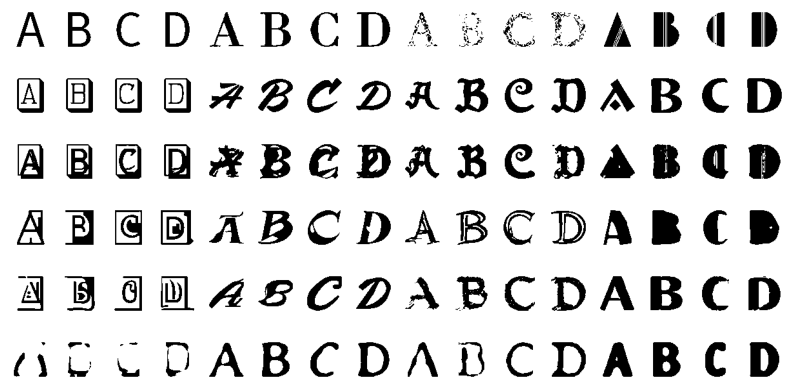

In [142]:
# 生成画像のサンプル myfonts
sample_imgs = {'FANnet': [], 'Condition': [], 'Noise': [], 'Image': [], 'style1': [], 'style2': []}
sample_num = 10
margin = 5
cate = 'MYFONTS_RANDOM'
not_eval_csv_path = 'csv_files/recognition_not_eval_font.csv'

df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_original-font'].to_list())

cnt = 0
imgsubname_list = []
path_list = ['result/letter_recognition/FANnet/MYFONTS_RANDOM/ff-meta-correspondence_feggolite_gt_A_pred_J.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/ff-meta-correspondence_feggolite_gt_B_pred_O.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/ff-meta-correspondence_feggolite_gt_C_pred_C.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/ff-meta-correspondence_feggolite_gt_D_pred_D.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/archive-modern-ii_mixed-tape-rough_gt_A_pred_A.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/archive-modern-ii_mixed-tape-rough_gt_B_pred_B.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/archive-modern-ii_mixed-tape-rough_gt_C_pred_C.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/archive-modern-ii_mixed-tape-rough_gt_D_pred_D.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/rephran_calaveras_gt_A_pred_A.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/rephran_calaveras_gt_B_pred_B.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/rephran_calaveras_gt_C_pred_C.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/rephran_calaveras_gt_D_pred_D.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/top-hat_bremen_gt_A_pred_A.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/top-hat_bremen_gt_B_pred_B.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/top-hat_bremen_gt_C_pred_C.png',
            'result/letter_recognition/FANnet/MYFONTS_RANDOM/top-hat_bremen_gt_D_pred_D.png'
]

for img_path in path_list:
    original_font = os.path.basename(img_path).split('_pred')[0]
    label = ord(original_font[-1]) - ord('A')
    if f'{cate}_{original_font}' in not_eval_font:
        continue

    img = cv2.imread(img_path, 0)
    sample_imgs['FANnet'].append(postprocessing(img, img_size=64, margin=margin))

    char = original_font[-1]
    style1_font = original_font.split('_')[0]
    style2_font = original_font.split('_')[1]
    style1_img = np.load(f'../font2img/myfonts/test/{style1_font}.npz')['arr_0'][ord(char) - ord('A')]
    style2_img = np.load(f'../font2img/myfonts/test/{style2_font}.npz')['arr_0'][ord(char) - ord('A')]
    sample_imgs['style1'].append(postprocessing(style1_img, img_size=64, margin=margin))
    sample_imgs['style2'].append(postprocessing(style2_img, img_size=64, margin=margin))

    imgsubname_list.append(original_font)

for approach in ['Condition', 'Noise', 'Image']:
    for imgsubname in imgsubname_list:
        try:
            img_path = glob.glob(f'result/letter_recognition/log39_fannet_retrain_step_final/{approach}/{cate}/{glob.escape(imgsubname)}*.png')[0]
        except:
            print(imgsubname)
            continue
        img = cv2.imread(img_path, 0)
        sample_imgs[approach].append(postprocessing(img, img_size=64, margin=margin))


fig, ax = plt.subplots(6, 16, figsize=(10, 5))

# plt.subplots_adjust(wspace=0.4, hspace=0.6)

for i in range(len(path_list)):
    ax[0, i].imshow(sample_imgs['style1'][i], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(sample_imgs['style2'][i], cmap='gray')
    ax[1, i].axis('off')
    ax[2, i].imshow(sample_imgs['Image'][i], cmap='gray')
    ax[2, i].axis('off')
    ax[3, i].imshow(sample_imgs['Condition'][i], cmap='gray')
    ax[3, i].axis('off')
    ax[4, i].imshow(sample_imgs['Noise'][i], cmap='gray')
    ax[4, i].axis('off')
    ax[5, i].imshow(sample_imgs['FANnet'][i], cmap='gray')
    ax[5, i].axis('off')



## Inception score

### save features

In [13]:
post_transform = Compose([transforms.ToTensor(), transforms.Resize((299, 299))])

category = 'MYFONTS_RANDOM'
not_eval_font = []
not_eval_csv_path = 'csv_files/recognition_not_eval_font.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_original-font'].to_list())

# Load image data
path_list = glob.glob(f'result/letter_recognition/FANnet/{category}/*.png')
imgs = []
real_imgs = []
labels = []
for img_path in path_list:
    original_font = os.path.basename(img_path).split('_pred')[0]
    label = ord(original_font[-1]) - ord('A')
    img = cv2.imread(img_path, 0)

    # char = original_font[-1]
    style1_font = original_font.split('_')[0]
    style2_font = original_font.split('_')[1]

    style1_img = np.load(f'../font2img/myfonts/test/{style1_font}.npz')['arr_0'][label]
    style2_img = np.load(f'../font2img/myfonts/test/{style2_font}.npz')['arr_0'][label]

    # if f'{category}_{original_font}' in not_eval_font:
    #     img = post_transform(img)
    # else:
    #     try:
    #         margin = 10
    #         img = post_transform(postprocessing(img, img_size=299, margin=margin))

    #     except:
    #         print(f'{original_font},FANnet')

    # img = torch.cat([img for _ in range(3)])
    # imgs.append(img)

    # real_img = post_transform(postprocessing(style1_img, img_size=299, margin=margin))
    # real_img = torch.cat([real_img for _ in range(3)])
    # real_imgs.append(real_img)

    real_img = post_transform(postprocessing(style2_img, img_size=299, margin=margin))
    real_img = torch.cat([real_img for _ in range(3)])
    real_imgs.append(real_img)

# imgs = torch.stack(imgs).float()
real_imgs = torch.stack(real_imgs).float()

# Load inception model
inception_block_idx = 2048
assert inception_block_idx in InceptionV3.BLOCK_INDEX_BY_DIM
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[inception_block_idx]
inception_v3 = InceptionV3([block_idx]).eval().to(device)

# Extract features
batch_size = 256

## fake
# features = []
# for i in range(0, len(imgs), batch_size):
#     img = imgs[i:i+batch_size].to(device)
#     with torch.no_grad():
#         feat = torch.cat(inception_v3(img)).squeeze(2).squeeze(2).cpu().detach().clone()
#     features.append(feat)

# features = np.concatenate(features, axis=0)
# # np.save('result/FANnet_fake_features.npy', features)
# np.save('result/FANnet_fake_features_no_exclusions.npy', features)

## real
features = []
for i in range(0, len(real_imgs), batch_size):
    img = real_imgs[i:i+batch_size].to(device)
    with torch.no_grad():
        feat = torch.cat(inception_v3(img)).squeeze(2).squeeze(2).cpu().detach().clone()
    features.append(feat)

features = np.concatenate(features, axis=0)
# np.save('result/real_features_style1.npy', features)
# np.save('result/real_features_style2.npy', features)
# np.save('result/real_features_style1_no_exclusions.npy', features)
np.save('result/real_features_style2_no_exclusions.npy', features)




### style1とstyle2を結合 ###
# s1 = np.load('result/real_features_style1_no_exclusions.npy')
# s2 = np.load('result/real_features_style2_no_exclusions.npy')

# s = np.concatenate([s1, s2], axis=0)
# np.save('result/real_features_style1_and_style2_no_exclusions.npy', s)


In [3]:
# DMのfake featuresを保存

post_transform = Compose([transforms.ToTensor(), transforms.Resize((299, 299))])


category = 'MYFONTS_RANDOM'
not_eval_font = []
approach_list = ['Condition', 'Noise', 'Image']
not_eval_csv_path = 'csv_files/recognition_not_eval_font.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_original-font'].to_list())

for approach in approach_list:
    # Load image data
    path_list = glob.glob(f'result/letter_recognition/log39_fannet_retrain_step_final/{approach}/{category}/*.png')
    imgs = []
    labels = []
    for img_path in path_list:
        original_font = os.path.basename(img_path).split('_pred')[0]
        label = ord(original_font[-1]) - ord('A')
        img = cv2.imread(img_path, 0)
        if f'{category}_{original_font}' in not_eval_font:
            img = post_transform(img)
        else:
            try:
                margin = 10
                img = post_transform(postprocessing(img, img_size=299, margin=margin))
            except:
                print(f'{original_font},{approach}')

        img = torch.cat([img for _ in range(3)])
        imgs.append(img)

    imgs = torch.stack(imgs).float()

    # Load inception model
    inception_block_idx = 2048
    assert inception_block_idx in InceptionV3.BLOCK_INDEX_BY_DIM
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[inception_block_idx]
    inception_v3 = InceptionV3([block_idx]).eval().to(device)

    # Extract fake features
    batch_size = 256
    features = []
    for i in range(0, len(imgs), batch_size):
        img = imgs[i:i+batch_size].to(device)
        with torch.no_grad():
            feat = torch.cat(inception_v3(img)).squeeze(2).squeeze(2).cpu().detach().clone()
        features.append(feat)

    features = np.concatenate(features, axis=0)
    np.save(f'result/{approach}_fake_features_no_exclusions.npy', features)


### cale IS

In [9]:
"""
FANnet : mean 1.1128225326538086, std 0.0013134402688592672
Image : mean 1.1220673322677612, std 0.0010160173987969756
Condition : mean 1.1144194602966309, std 0.0009968312224373221
Noise : mean 1.1174464225769043, std 0.0008918744279071689
"""

"""除外なし
FANnet : mean 1.1183942556381226, std 0.001191195216961205
Image : mean 1.1254994869232178, std 0.0010214817011728883
Condition : mean 1.1175556182861328, std 0.0010812395485118032
Noise : mean 1.1205673217773438, std 0.0010428427485749125
"""

def safe_log(x):
    return np.log(x + 1e-10)

def compute_is(fake_features, num_gen, num_splits):
    scores = []
    for i in range(num_splits):
        part = fake_features[i * num_gen // num_splits : (i + 1) * num_gen // num_splits]
        kl = part * (safe_log(part) - safe_log(np.mean(part, axis=0, keepdims=True)))
        kl = np.mean(np.sum(kl, axis=1))
        scores.append(np.exp(kl))
    return float(np.mean(scores)), float(np.std(scores))

approach_list = ['FANnet', 'Image', 'Condition', 'Noise', ]

for approach in approach_list:
    fake_features = np.load(f'result/{approach}_fake_features_no_exclusions.npy')
    fake_features = fake_features[:, np.newaxis, :]
    num_gen = fake_features.shape[0]

    mean, std = compute_is(fake_features, num_gen, 16)
    print(f'{approach} : mean {mean}, std {std}')

FANnet : mean 1.1183942556381226, std 0.001191195216961205
Image : mean 1.1254994869232178, std 0.0010214817011728883
Condition : mean 1.1175556182861328, std 0.0010812395485118032
Noise : mean 1.1205673217773438, std 0.0010428427485749125


## recall/precision

In [10]:
"""
real_faet: style1のみ
Image : precision 0.49975264072418213, recall 0.6726583242416382
Condition : precision 0.6057882308959961, recall 0.6962401270866394
Noise : precision 0.6089215278625488, recall 0.7085257172584534
FANnet : precision 0.6896438002586365, recall 0.0508740097284317

real_feat: style2のみ
Image : precision 0.4942282438278198, recall 0.6590534448623657
Condition : precision 0.5822064876556396, recall 0.6899735927581787
Noise : precision 0.6029848456382751, recall 0.7228726744651794
FANnet : precision 0.7124835252761841, recall 0.0502968356013298

real_feat: style1とstyle2
Image : precision 0.5169854760169983, recall 0.665855884552002
Condition : precision 0.5826187133789062, recall 0.6931068897247314
Noise : precision 0.5931728482246399, recall 0.7156991958618164
FANnet : precision 0.7093502879142761, recall 0.05058542266488075
"""

"""除外なし
real_feat: style1とstyle2
FANnet : precision 0.6598461270332336, recall 0.05061538517475128
Image : precision 0.47961539030075073, recall 0.6486923098564148
Condition : precision 0.539307713508606, recall 0.6763461828231812
Noise : precision 0.548153817653656, recall 0.7088077068328857
"""

def compute_distances(row_features, col_features, num_gpus, rank, col_batch_size):
    assert 0 <= rank < num_gpus
    num_cols = col_features.shape[0]
    num_batches = ((num_cols - 1) // col_batch_size // num_gpus + 1) * num_gpus
    col_batches = torch.nn.functional.pad(col_features, [0, 0, 0, -num_cols % num_batches]).chunk(num_batches)
    dist_batches = []
    for col_batch in col_batches[rank :: num_gpus]:
        dist_batch = torch.cdist(row_features.unsqueeze(0), col_batch.unsqueeze(0))[0]
        for src in range(num_gpus):
            dist_broadcast = dist_batch.clone()
            if num_gpus > 1:
                torch.distributed.broadcast(dist_broadcast, src=src)
            dist_batches.append(dist_broadcast.cpu() if rank == 0 else None)
    return torch.cat(dist_batches, dim=1)[:, :num_cols] if rank == 0 else None

def compute_pr(real_features, fake_features, nhood_size=3, row_batch_size=10000, col_batch_size=10000, rank=0, num_gpus=1):
    results = dict()
    for name, manifold, probes in [('precision', real_features, fake_features), ('recall', fake_features, real_features)]:
        kth = []
        for manifold_batch in manifold.split(row_batch_size):
            dist = compute_distances(row_features=manifold_batch, col_features=manifold, num_gpus=num_gpus, rank=rank, col_batch_size=col_batch_size)
            kth.append(dist.to(torch.float32).kthvalue(nhood_size + 1).values.to(torch.float16) if rank == 0 else None)
        kth = torch.cat(kth) if rank == 0 else None
        pred = []
        for probes_batch in probes.split(row_batch_size):
            dist = compute_distances(row_features=probes_batch, col_features=manifold, num_gpus=num_gpus, rank=rank, col_batch_size=col_batch_size)
            pred.append((dist <= kth).any(dim=1) if rank == 0 else None)
        results[name] = float(torch.cat(pred).to(torch.float32).mean() if rank == 0 else 'nan')
    return results['precision'], results['recall']


approach_list = ['FANnet', 'Image', 'Condition', 'Noise', ]

# real_features = np.load('result/real_features_style1.npy')
# real_features = np.load('result/real_features_style2.npy')
real_features = np.load('result/real_features_style1_and_style2_no_exclusions.npy')
for approach in approach_list:
    fake_features = np.load(f'result/{approach}_fake_features_no_exclusions.npy')

    precision, recall = compute_pr(torch.tensor(real_features), torch.tensor(fake_features))
    print(f'{approach} : precision {precision}, recall {recall}')


FANnet : precision 0.6598461270332336, recall 0.05061538517475128
Image : precision 0.47961539030075073, recall 0.6486923098564148
Condition : precision 0.539307713508606, recall 0.6763461828231812
Noise : precision 0.548153817653656, recall 0.7088077068328857


# FANnet interpolation

In [44]:
# データの読み込み
fannet_path = f'./weight/style_encoder_fannet_retrain.pth'

fannet = FANnet(num_class)
fannet.to(device)
fannet.load_state_dict(torch.load(fannet_path, map_location=device))
fannet.eval()

data_list = {'train': [], 'val': [], 'test': []}
transform = Compose([transforms.ToTensor(),])
image_size = 64
margin = 5

for data_type in ['train', 'val', 'test']:
    path_list = glob.glob(f'../font2img/myfonts/{data_type}/*')

    imgs = []
    for i in range(len(path_list)):
        for label in range(num_class):
            img = np.load(path_list[i])['arr_0'][label]
            img = transform(preprocessing_myfonts(img, img_size=image_size, margin=margin)).float()

            data_list[data_type].append((img, torch.tensor(label)))

print('TRAIN SIZE: {}'.format(len(data_list['train'])))
print('VAL SIZE: {}'.format(len(data_list['val'])))
print('TEST SIZE: {}'.format(len(data_list['test'])))

TRAIN SIZE: 362388
VAL SIZE: 45084
TEST SIZE: 45240


In [ ]:
# 生成
char = 'A'
num_split = 100
interpolation_seed = 1
data_type = 'test' # 'train' or 'val' or 'test'
save_img_parenet_dir = 'result/pick_interpolation/FANnet'

freeze_seed(interpolation_seed)

# train
# pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198)]
# pair_id = [(275, 185), (284, 249), ]
# pair_id = [(222, 275), (28, 40), (91, 184)]
pair_id = [(222, 275), (28, 40), (91, 184), (91, 494), (185, 198),
            (284, 249), (284, 494), (710, 494), (693, 769), (275, 185), (284, 249),
            (91, 406), (80, 471), (2, 3), ]
pair_id = [(7, 21), (10, 20), (79, 85), (144, 164), (166, 171), (132, 133)]
pair_id = [(random.randint(0, 13000), random.randint(0, 13000)) for _ in range(10)]
pair_id = [(56, 184), (77, 222), (460, 461), (24, 40), (521, 550)]

# pair_id = [(222, 275), (91, 494)]
# pair_id = [(2, 3), (2, 6)]


# test
# pair_id = [(50, 81), (703, 727), (909, 918), ]
pair_id = [(172, 296),(34, 727),(849, 830),(50, 172),(54, 343),(166, 950),]


# google font
# pair_id = [(44,45), (90, 91), (20, 21)]

data = data_list[data_type]

for style1_id, style2_id in pair_id:
    alphas = torch.tensor([i/(num_split-1) for i in range(num_split)]).to(device)
    b = alphas.shape[0]
    style1 = torch.stack([data[style1_id*num_class + (ord(char) - ord('A'))][0] for _ in range(b)]).to(device)
    style2 = torch.stack([data[style2_id*num_class + (ord(char) - ord('A'))][0] for _ in range(b)]).to(device)
    label = nn.functional.one_hot(torch.tensor(ord(char) - ord('A')), num_classes=num_class).float()
    label = torch.stack([label for _ in range(b)]).to(device)


    with torch.no_grad():
        feat_s1 = fannet.enc_img(style1)
        feat_s2 = fannet.enc_img(style2)
        feat_x = torch.stack([alpha*s1 + (1-alpha)*s2 for s1, s2, alpha in zip(feat_s1, feat_s2, alphas)])
        feat_label = fannet.enc_label(label)

        feat = torch.cat((feat_x, feat_label), axis=1)
        feat = fannet.enc(feat)
        feat = feat.reshape(-1, 16, 8, 8)
        x = fannet.dec(feat)

    fig, ax = plt.subplots(10, 12, figsize=(12, 10))
    for i in range(b):
        ax[i//10, i%10+1].axis('off')
        ax[i//10, i%10+1].imshow(x[i][0].cpu().detach(), cmap='gray')

    style1_and_style2 = torch.stack([data[num_class*i + (ord(char) - ord('A'))][0] for i in [style1_id, style2_id]])
    ax[0, 0].imshow(style1_and_style2[1][0].cpu().detach(), cmap='gray')
    ax[9, 11].imshow(style1_and_style2[0][0].cpu().detach(), cmap='gray')

    for i in range(10):
        ax[i, 0].axis('off')
        ax[i, 11].axis('off')

    plt.savefig(f"result/{os.path.basename(fannet_path).split('.')[0]}_interpolate_{dataset_name}_{data_type}_char_{char}_style_{style1_id}_{style2_id}.png")
    plt.show()

    # save generated image
    folder_name = f'{dataset_name}_{data_type}_{char}_style_{style1_id}_{style2_id}'
    save_dir = os.path.join(save_img_parenet_dir, os.path.basename(fannet_path).split('.')[0], folder_name)
    os.makedirs(save_dir, exist_ok=True)
    save_filename = [str(i) + '_' + str(a.item()) for i, a in enumerate(alphas)]
    save_generated_image(x.cpu().detach(), save_dir, save_filename)

    # save style1 and style2
    save_style_filename = ['style1', 'style2']
    save_generated_image(style1_and_style2, save_dir, save_style_filename)



# 図

## fig1

In [ ]:
category = 'SANS_SERIF' #['SERIF', 'SANS_SERIF', 'DISPLAY', 'HANDWRITING']
not_eval_csv_path = 'csv_files/weight_not_eval_font.csv'
approach_list = ['Noise', 'Condition', 'Image']

post_transform = Compose([
                        transforms.ToTensor(),
                        ])
df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_font_char'].to_list())
margin = 10
sample_num = 1
style1_imgs = []
style2_imgs = []
cate_imgname_list = []
cnt = 0

path_list = glob.glob(f'result/weight_interpolation/log39_fannet_retrain_step_final/Noise/{category}/*_A.png')
se = 69
freeze_seed(se) # sans-serif:69, serif: 70
random.shuffle(path_list)
for img_path in path_list:
    if cnt >= sample_num:
        break

    fontname = os.path.basename(img_path).split('_')[0]
    char = os.path.basename(img_path).split('_')[1][0]
    if f'{category}_{fontname}_{char}' in not_eval_font:
        continue

    img = cv2.imread(img_path, 0)
    img = postprocessing(img, img_size=64, margin=margin, binarization=False)

    style1_name = fontname.replace('Medium', 'Light')
    style1 = cv2.imread(f'../font2img/image/{style1_name}/{char}.png', 0)
    style1 = postprocessing(style1, img_size=64, margin=margin, binarization=False)

    style2_name = fontname.replace('Medium', 'Bold')
    style2 = cv2.imread(f'../font2img/image/{style2_name}/{char}.png', 0)
    style2 = postprocessing(style2, img_size=64, margin=margin, binarization=False)

    cnt += 1

plt.imshow(style1, cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()


plt.imshow(style2, cmap='gray')
plt.axis('off')
plt.show()

## style-examples

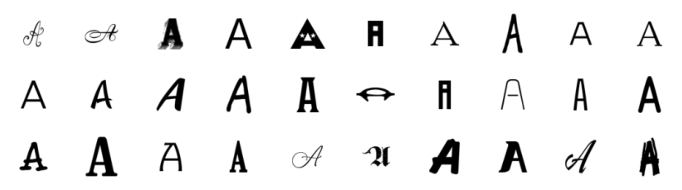

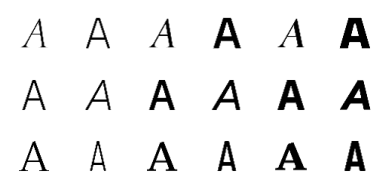

In [99]:
# 100フォント見る（上から100）
fig, ax = plt.subplots(3, 10, figsize=(7, 2))
path_list = glob.glob(f'../font2img/myfonts/train/*')
for i in range(30):
    img = np.load(path_list[i])['arr_0'][0]
    img = preprocessing_myfonts(img, img_size=64, margin=5)

    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].imshow(img, cmap='gray')
plt.tight_layout()
plt.show()

# 100フォント見る（上から100）
fig, ax = plt.subplots(3, 6, figsize=(4, 2))
df = pd.read_csv('csv_files/weight_interpolation.csv').sample(6, random_state=0)
for i, (_, row) in enumerate(df.iterrows()):
    light_img = cv2.imread(os.path.join('../font2img/image', row['Light'], "A.png"), 0)
    light_img = preprocessing(light_img, img_size=64, margin=40)

    medium_img = cv2.imread(os.path.join('../font2img/image', row['Medium'], "A.png"), 0)
    medium_img = preprocessing(medium_img, img_size=64, margin=40)

    bold_img = cv2.imread(os.path.join('../font2img/image', row['Bold'], "A.png"), 0)
    bold_img = preprocessing(bold_img, img_size=64, margin=40)

    ax[i//2, i%2].axis('off')
    ax[i//2, i%2].imshow(light_img, cmap='gray')

    ax[i//2, i%2 + 2].axis('off')
    ax[i//2, i%2 + 2].imshow(medium_img, cmap='gray')

    ax[i//2, i%2 + 4].axis('off')
    ax[i//2, i%2 + 4].imshow(bold_img, cmap='gray')

plt.tight_layout()
plt.show()

## qualitative-style-parameter 

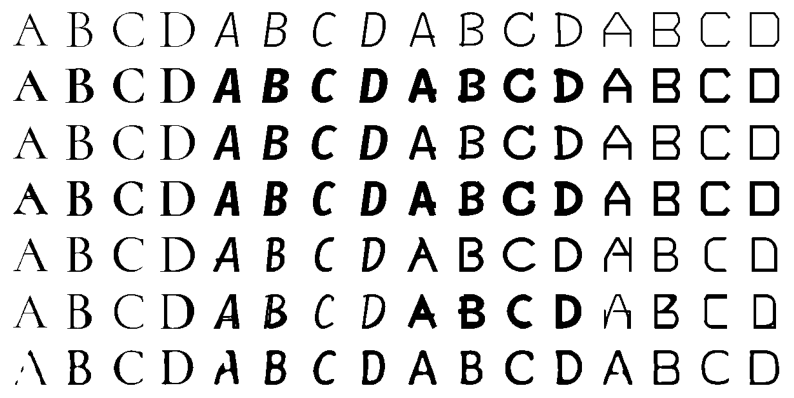

In [83]:

# [qualitative-style-parameter]​
# weight interpolationの生成例を見る
# 3つのアプローチについて各カテゴリ2つずつの生成結果とstyle1, style2, GTを見る

category_list = ['SERIF', 'SANS_SERIF', 'HANDWRITING', 'DISPLAY']
not_eval_csv_path = 'csv_files/weight_not_eval_font.csv'
approach_list = ['Noise', 'Condition', 'Image']

post_transform = Compose([
                        transforms.ToTensor(),
                        ])
df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_font_char'].to_list())
margin = 5
char_num = 4
gt_imgs = []
style1_imgs = []
style2_imgs = []
cate_imgname_list = []
filenames = {'SERIF': 'CormorantUnicase-Medium_A.png',
            'SANS_SERIF': 'FiraSansCondensed-MediumItalic_A.png',
            'HANDWRITING': 'Mali-Medium_A.png',
            'DISPLAY': 'TurretRoad-Medium_A.png',}

for cate in category_list:
    base_img_path = f'result/weight_interpolation/log39_fannet_retrain_step_final/Noise/{cate}/{filenames[cate]}'

    for char in [chr(ord('A') + i) for i in range(char_num)]:
        img_path = base_img_path.replace('_A.png', f'_{char}.png')

        fontname = os.path.basename(img_path).split('_')[0]
        char = os.path.basename(img_path).split('_')[1][0]
        if f'{cate}_{fontname}_{char}' in not_eval_font:
            print('ahi')
            continue

        cate_imgname_list.append(cate+ '/' + os.path.basename(img_path))

        gt = cv2.imread(f'../font2img/image/{fontname}/{char}.png', 0)
        gt_imgs.append(postprocessing(gt, img_size=64, margin=margin))

        style1_name = fontname.replace('Medium', 'Light')
        style1 = cv2.imread(f'../font2img/image/{style1_name}/{char}.png', 0)
        style1_imgs.append(postprocessing(style1, img_size=64, margin=margin))

        style2_name = fontname.replace('Medium', 'Bold')
        style2 = cv2.imread(f'../font2img/image/{style2_name}/{char}.png', 0)
        style2_imgs.append(postprocessing(style2, img_size=64, margin=margin))


# 3つのアプローチ
imgs = {a: [] for a in approach_list}
for approach in approach_list:
    for cate_imgname in cate_imgname_list:
        img = cv2.imread(f'result/weight_interpolation/log39_fannet_retrain_step_final/{approach}/{cate_imgname}', 0)
        imgs[approach].append(postprocessing(img, img_size=64, margin=margin))

# FANnet
imgs['FANnet'] = []
for cate_imgname in cate_imgname_list:
    img = cv2.imread(f'result/weight_interpolation/FANnet/{cate_imgname}', 0)
    imgs['FANnet'].append(postprocessing(img, img_size=64, margin=margin))

fig, ax = plt.subplots(7, char_num*len(category_list), figsize=(10, 5))

for i in range(char_num*len(category_list)):
    ax[0, i].imshow(style1_imgs[i], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(style2_imgs[i], cmap='gray')
    ax[1, i].axis('off')
    ax[2, i].imshow(gt_imgs[i], cmap='gray')
    ax[2, i].axis('off')
    ax[3, i].imshow(imgs['Image'][i], cmap='gray')
    ax[3, i].axis('off')
    ax[4, i].imshow(imgs['Condition'][i], cmap='gray')
    ax[4, i].axis('off')
    ax[5, i].imshow(imgs['Noise'][i], cmap='gray')
    ax[5, i].axis('off')
    ax[6, i].imshow(imgs['FANnet'][i], cmap='gray')
    ax[6, i].axis('off')


## qualitative-similar

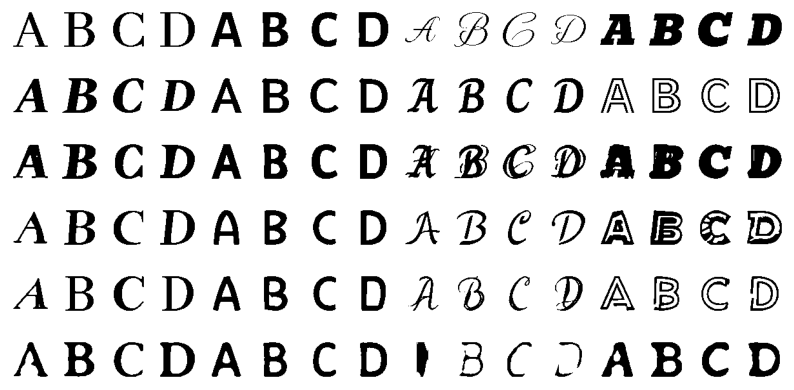

In [144]:

# [qualitative-similar]
# letter recognitionの生成例を見る
# 3つのアプローチについて各カテゴリ2つずつの生成結果とstyle1, style2を見る

category_list = ['SERIF', 'SANS_SERIF', 'HANDWRITING', 'DISPLAY']
not_eval_csv_path = 'csv_files/recognition_not_eval_font.csv'
approach_list = ['Noise', 'Condition', 'Image']

post_transform = Compose([
                        transforms.ToTensor(),
                        ])
df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_original-font'].to_list())
margin = 5
char_num = 4
style1_imgs = []
style2_imgs = []
cate_imgsubname_list = []
filenames = {'SERIF': 'AbhayaLibre-Medium_Spectral-ExtraBoldItalic_gt_A_pred_A.png',
            'SANS_SERIF': 'AlegreyaSans-Bold_Niramit-SemiBold_gt_A_pred_A.png',
            'HANDWRITING': 'MonteCarlo-Regular_Charm-Bold_gt_A_pred_A.png',
            'DISPLAY': 'Bevan-Italic_TrainOne-Regular_gt_A_pred_A.png'
            }

# H: MonteCarlo-Regular_Charm-Bold_gt_A_pred_A.png !!!!!
# KleeOne-Regular_DeliusSwashCaps-Regular_gt_A_pred_A.png
# Tillana-SemiBold_IndieFlower-Regular_gt_A_pred_A.png

# D: PressStart2P-Regular_Pushster-Regular_gt_A_pred_A.png
# Bevan-Italic_TrainOne-Regular_gt_A_pred_A.png  !!!!
# Corben-Regular_Miltonian-Regular_gt_A_pred_A.png


# a = 0
# h = glob.glob('result/letter_recognition/FANnet/HANDWRITING/*_gt_A_*.png')
# d = glob.glob('result/letter_recognition/FANnet/DISPLAY/*_gt_A_*.png')
# filenames['HANDWRITING'] = os.path.basename(h[a])
# filenames['DISPLAY'] = os.path.basename(d[a])
# print(filenames['HANDWRITING'])
# print(filenames['DISPLAY'])
# a += 1

for cate in category_list:
    base_img_path = f'result/letter_recognition/log39_fannet_retrain_step_final/Noise/{cate}/{filenames[cate]}'

    for char in [chr(ord('A') + i) for i in range(char_num)]:
        img_path = base_img_path.replace('gt_A_', f'gt_{char}_')
        img_path = glob.glob(glob.escape(img_path.split('_pred')[0]) + '*.png')[0]

        original_font = os.path.basename(img_path).split('_pred')[0]
        label = ord(original_font[-1]) - ord('A')
        if f'{cate}_{original_font}' in not_eval_font:
            continue

        cate_imgsubname_list.append(cate + '/' + original_font)

        char = original_font[-1]
        style1_font = original_font.split('_')[0]
        style2_font = original_font.split('_')[1]
        style1_img = cv2.imread(f'../font2img/image/{style1_font}/{char}.png', 0)
        style2_img = cv2.imread(f'../font2img/image/{style2_font}/{char}.png', 0)
        style1_imgs.append(postprocessing(style1_img, img_size=64, margin=margin))
        style2_imgs.append(postprocessing(style2_img, img_size=64, margin=margin))

# 3つのアプローチ
imgs = {a: [] for a in approach_list}
for approach in approach_list:
    for cate_imgname in cate_imgsubname_list:
        img_path = glob.glob(f'result/letter_recognition/log39_fannet_retrain_step_final/{approach}/{glob.escape(cate_imgname)}*.png')[0]
        img = cv2.imread(img_path, 0)
        imgs[approach].append(postprocessing(img, img_size=64, margin=margin))

# FANnet
imgs['FANnet'] = []
for cate_imgname in cate_imgsubname_list:
    img_path = glob.glob(f'result/letter_recognition/FANnet/{glob.escape(cate_imgname)}*.png')[0]
    img = cv2.imread(img_path, 0)
    imgs['FANnet'].append(postprocessing(img, img_size=64, margin=margin))

fig, ax = plt.subplots(6, char_num*len(category_list), figsize=(10, 5))

for i in range(char_num*len(category_list)):
    ax[0, i].imshow(style1_imgs[i], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(style2_imgs[i], cmap='gray')
    ax[1, i].axis('off')
    ax[2, i].imshow(imgs['Image'][i], cmap='gray')
    ax[2, i].axis('off')
    ax[3, i].imshow(imgs['Condition'][i], cmap='gray')
    ax[3, i].axis('off')
    ax[4, i].imshow(imgs['Noise'][i], cmap='gray')
    ax[4, i].axis('off')
    ax[5, i].imshow(imgs['FANnet'][i], cmap='gray')
    ax[5, i].axis('off')



## qualitative-different

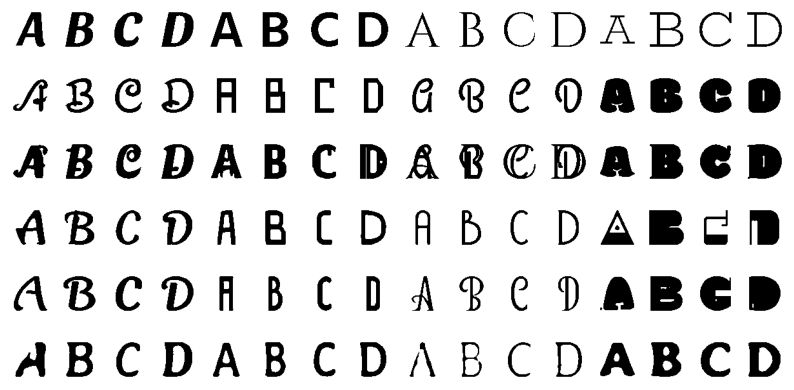

In [44]:
# [qualitative-different]
# letter recognitionの random pair の生成例を見る
# 3つのアプローチについて8つずつの生成結果とstyle1, style2を見る

category = 'RANDOM'
not_eval_csv_path = 'csv_files/recognition_not_eval_font.csv'
approach_list = ['Noise', 'Condition', 'Image']

post_transform = Compose([
                        transforms.ToTensor(),
                        ])
df = pd.read_csv(not_eval_csv_path)
not_eval_font = set(df['cate_original-font'].to_list())
margin = 5
char_num = 4
style1_imgs = []
style2_imgs = []
cate_imgsubname_list = []
filenames = ['Sansita-BoldItalic_YujiMai-Regular_gt_A_pred_A.png',
            'HindColombo-SemiBold_Geo-Regular_gt_A_pred_R.png',
            'Cinzel[wght]_GrandHotel-Regular_gt_A_pred_A.png',
            'BioRhyme-Light_Modak-Regular_gt_A_pred_Q.png',]


for f in filenames:
    base_img_path = glob.glob(f'result/letter_recognition/log39_fannet_retrain_step_final/Noise/{category}/{glob.escape(f)}')[0]

    for char in [chr(ord('A') + i) for i in range(char_num)]:
        img_path = base_img_path.replace('gt_A_', f'gt_{char}_')
        img_path = glob.glob(glob.escape(img_path.split('_pred')[0]) + '*.png')[0]

        original_font = os.path.basename(img_path).split('_pred')[0]
        label = ord(original_font[-1]) - ord('A')
        if f'{category}_{original_font}' in not_eval_font:
            continue

        cate_imgsubname_list.append(category + '/' + original_font)

        char = original_font[-1]
        style1_font = original_font.split('_')[0]
        style2_font = original_font.split('_')[1]
        style1_img = cv2.imread(f'../font2img/image/{style1_font}/{char}.png', 0)
        style2_img = cv2.imread(f'../font2img/image/{style2_font}/{char}.png', 0)
        style1_imgs.append(postprocessing(style1_img, img_size=64, margin=margin))
        style2_imgs.append(postprocessing(style2_img, img_size=64, margin=margin))

# 3つのアプローチ
imgs = {a: [] for a in approach_list}
for approach in approach_list:
    for cate_imgname in cate_imgsubname_list:
        img_path = glob.glob(f'result/letter_recognition/log39_fannet_retrain_step_final/{approach}/{glob.escape(cate_imgname)}*.png')[0]
        img = cv2.imread(img_path, 0)
        imgs[approach].append(postprocessing(img, img_size=64, margin=margin))

# FANnet
imgs['FANnet'] = []
for cate_imgname in cate_imgsubname_list:
    img_path = glob.glob(f'result/letter_recognition/FANnet/{glob.escape(cate_imgname)}*.png')[0]
    img = cv2.imread(img_path, 0)
    imgs['FANnet'].append(postprocessing(img, img_size=64, margin=margin))

fig, ax = plt.subplots(6, char_num*len(category_list), figsize=(10, 5))

for i in range(char_num*len(category_list)):
    ax[0, i].imshow(style1_imgs[i], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(style2_imgs[i], cmap='gray')
    ax[1, i].axis('off')
    ax[2, i].imshow(imgs['Image'][i], cmap='gray')
    ax[2, i].axis('off')
    ax[3, i].imshow(imgs['Condition'][i], cmap='gray')
    ax[3, i].axis('off')
    ax[4, i].imshow(imgs['Noise'][i], cmap='gray')
    ax[4, i].axis('off')
    ax[5, i].imshow(imgs['FANnet'][i], cmap='gray')
    ax[5, i].axis('off')

    #BioRhyme-Light_Modak-Regular_gt_A_pred_Q.png
    #oppioOne-Regular_Frijole-Regular_gt_A_pred_A.png
    #Sansita-BoldItalic_YujiMai-Regular_gt_A_pred_A.png

## qualitative-various-lambda

Condition


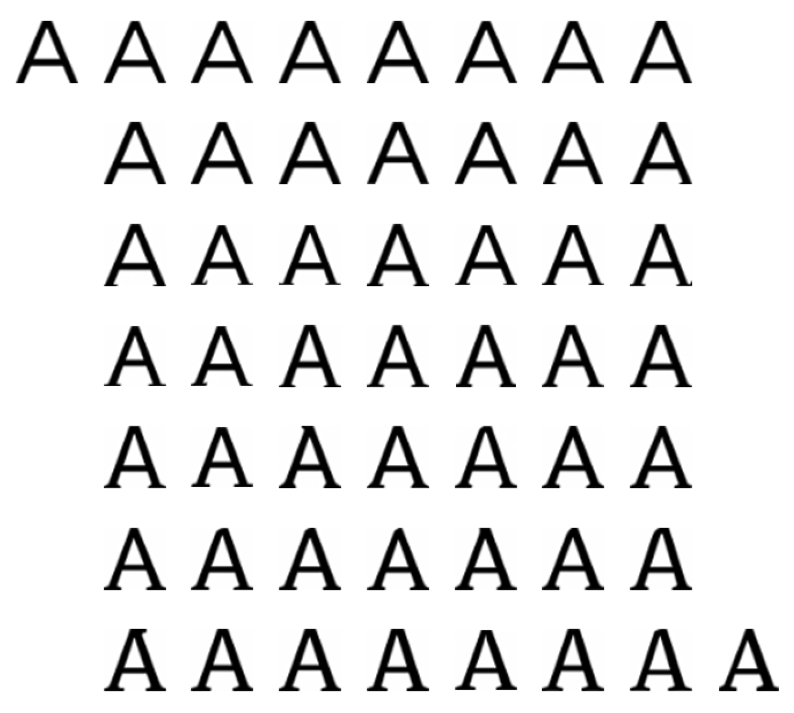

Noise


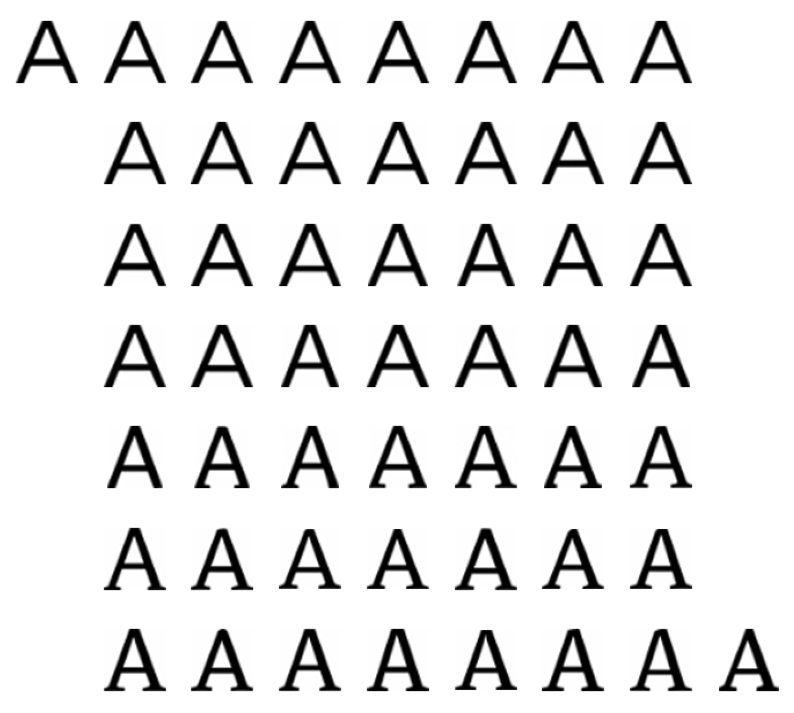

In [57]:
# いろんなλのやつの生成画像をクロップしてまた並べる
def show_various_lambda(save_img_path, red_char_index):
    margin = 5
    generated_img_path_list = glob.glob(save_img_path + '/*_*.png')
    generated_img_path_list = sorted(generated_img_path_list, key=lambda x: int(os.path.basename(x).split('_')[0]))
    style_img_path_list = [os.path.join(save_img_path, 'style1.png'), os.path.join(save_img_path, 'style2.png')]

    generated_img = []
    for i, p in enumerate(generated_img_path_list):
        img = cv2.imread(p, 0)
        img = postprocessing(img, img_size=64, margin=margin, binarization=False)

        if i in red_char_index:
            print(os.path.basename(p))
            # 赤くする
            img = np.stack([img, img, img], axis=-1)
            img[:, :, 0] = 1. # R次元

        generated_img.append(img)

    style_img = []
    for p in style_img_path_list:
        img = cv2.imread(p, 0)
        img = postprocessing(img, img_size=64, margin=margin, binarization=False)
        style_img.append(img)

    fig, ax = plt.subplots(7, 9, figsize=(10, 9))
    for i in range(49):
        ax[i//7, i%7+1].axis('off')
        ax[i//7, i%7+1].imshow(generated_img[i], cmap='gray')

    ax[0, 0].imshow(style_img[1], cmap='gray')
    ax[6, 8].imshow(style_img[0], cmap='gray')

    for i in range(7):
        ax[i, 0].axis('off')
        ax[i, 8].axis('off')

    plt.show()

# print('Condition')
# red_char_index = [15, 16, 17, 18, 19]
# save_img_path = 'result/pick_interpolation/Condition/log39_fannet_retrain_step_final/qualitative_decorative_style_710_494'
# show_various_lambda(save_img_path, red_char_index)

# print('Noise')
# red_char_index = [20, 23, 25]
# save_img_path = 'result/pick_interpolation/Noise/log39_fannet_retrain_step_final/qualitative_decorative_style_710_494'
# show_various_lambda(save_img_path, red_char_index)

# print('Condition')
# red_char_index = []
# save_img_path = 'result/pick_interpolation/Condition/log39_fannet_retrain_step_final/qualitative_decorative_style_79_85'
# show_various_lambda(save_img_path, red_char_index)

# print('Noise')
# red_char_index = []
# save_img_path = 'result/pick_interpolation/Noise/log39_fannet_retrain_step_final/qualitative_decorative_style_79_85'
# show_various_lambda(save_img_path, red_char_index)

# test
print('Condition')
red_char_index = []
save_img_path = 'result/pick_interpolation/Condition/log39_fannet_retrain_step_final/qualitative_decorative_test_style_1414_1466'
show_various_lambda(save_img_path, red_char_index)

print('Noise')
red_char_index = []
save_img_path = 'result/pick_interpolation/Noise/log39_fannet_retrain_step_final/qualitative_decorative_test_style_1414_1466'
show_various_lambda(save_img_path, red_char_index)

# print('Condition')
# red_char_index = [19, 21, 24, 25, 26, 27, 29, 30]
# red_char_index = []
# save_img_path = 'result/pick_interpolation/Condition/log39_fannet_retrain_step_final/qualitative_decorative_test_style_583_830'
# show_various_lambda(save_img_path, red_char_index)

# print('Noise')
# red_char_index = [7, 8, 12, 14, 15, 21, 26, 30]
# red_char_index = []
# save_img_path = 'result/pick_interpolation/Noise/log39_fannet_retrain_step_final/qualitative_decorative_test_style_583_830'
# show_various_lambda(save_img_path, red_char_index)

## qualitative-decorative

approach: Image, font_id: 172, 296, img_path: generated.png
approach: Image, font_id: 34, 727, img_path: generated.png
approach: Image, font_id: 849, 830, img_path: generated.png
approach: Image, font_id: 50, 172, img_path: generated.png
approach: Image, font_id: 54, 343, img_path: generated.png
approach: Image, font_id: 166, 950, img_path: generated.png
approach: Condition, font_id: 172, 296, img_path: 30_0.30303030303030304.png
approach: Condition, font_id: 34, 727, img_path: 59_0.5959595959595959.png
approach: Condition, font_id: 849, 830, img_path: 44_0.4444444444444444.png
approach: Condition, font_id: 50, 172, img_path: 33_0.3333333333333333.png
approach: Condition, font_id: 54, 343, img_path: 51_0.5151515151515151.png
approach: Condition, font_id: 166, 950, img_path: 43_0.43434343434343436.png
approach: Noise, font_id: 172, 296, img_path: 61_0.6161616444587708.png
approach: Noise, font_id: 34, 727, img_path: 62_0.6262626051902771.png
approach: Noise, font_id: 849, 830, img_path:

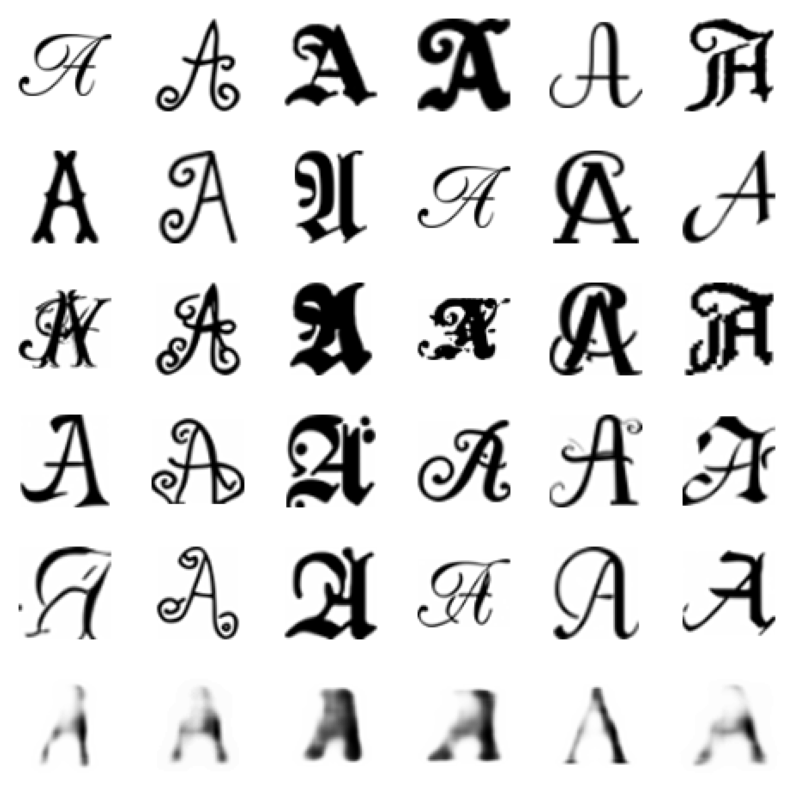

In [31]:
# 特定の生成結果をクロップして並べる
"""
(a) Image, (b) Condition, (c) Noise (d) FANnet
24, 40 → Condition:  21_0.21, Noise:  67_0.68, FANnet: 49_0.50
1537, 7993 → Condition:  43_0.43, Noise:  50_0.51, FANnet: 49_0.50
12922, 3439 → Condition:  82_0.83, Noise:  51_0.52, FANnet: 49_0.50
77, 222 → Condition: 53_0.54  , Noise:  69_0.70, FANnet: 49_0.50
28, 40 → Condition:  44_0.44, Noise: 28_0.28, FANnet: 70_0.71
284, 249 → Condition:  50_0.51, Noise: 54_0.55, FANnet: 49_0.50

test
172, 296, 30, 61, 49
34, 727, 59, 62, 49
849, 830, 44, 40, 49
50, 172, 33, 30, 60
54, 343, 51, 83, 40
166, 950, 43, 43, 60


"""

margin = 5
style_img = {'style1': [], 'style2': []}
approach_list = ['Image', 'Condition', 'Noise', 'FANnet']
generate_img = {a: [] for a in approach_list}
data_type = 'test'

# (style1_id, style2_id, condition_id, noise_id, fannet_id)
# train
# font_id = [(24, 40, 21, 67, 49), (1537, 7993, 43, 50, 49), (12922, 3439, 82, 51, 49), (77, 222, 53, 69, 49), (28, 40, 44, 28, 70), (284, 249, 50, 54, 49)]
# test
font_id = [(172, 296, 30, 61, 49),(34, 727, 59, 62, 49),(849, 830, 44, 40, 49),(50, 172, 33, 30, 60),(54, 343, 51, 83, 40),(166, 950, 43, 43, 60)]

save_dir_path = {a: [] for a in approach_list}
for s1, s2, _, _, _ in font_id:
    save_dir_path['Noise'] += glob.glob(f'result/pick_interpolation/Noise/log39_fannet_retrain_step_final/ddim_myfonts_{data_type}_scale_3.0_3.0_A_style_{s1}_{s2}')
    save_dir_path['Condition'] += glob.glob(f'result/pick_interpolation/Condition/log39_fannet_retrain_step_final/ddim_myfonts_{data_type}_scale_3.0_3.0_A_style_{s1}_{s2}')
    save_dir_path['Image'] += glob.glob(f'result/pick_interpolation/Image/log39_fannet_retrain_step_final/myfonts_{data_type}_t_500_scale_0.0_0.0_0.0_A_style_{s1}_{s2}')
    save_dir_path['FANnet'] += glob.glob(f'result/pick_interpolation/FANnet/style_encoder_fannet_retrain/myfonts_{data_type}_A_style_{s1}_{s2}')

for approach in approach_list:
    for i in range(len(font_id)):
        if approach == 'Condition':
            img_path =  glob.glob(save_dir_path[approach][i] + f'/{font_id[i][2]}_*.png')[0]
        elif approach == 'Noise':
            img_path =  glob.glob(save_dir_path[approach][i] + f'/{font_id[i][3]}_*.png')[0]
        elif approach == 'Image':
            img_path = save_dir_path[approach][i] + '/generated.png'
        elif approach == 'FANnet':
            img_path = glob.glob(save_dir_path[approach][i] + f'/{font_id[i][4]}_*.png')[0]

        print(f'approach: {approach}, font_id: {font_id[i][0]}, {font_id[i][1]}, img_path: {os.path.basename(img_path)}')

        img = cv2.imread(img_path, 0)

        if approach == 'FANnet':
            img = img[5:-5, 5:-5]
            img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
        else:
            img = postprocessing(img, img_size=64, margin=margin, binarization=False)
        generate_img[approach].append(img)

for dir_path in save_dir_path['Noise']:
    style1_path = dir_path + '/style1.png'
    style2_path = dir_path + '/style2.png'

    style1_img = cv2.imread(style1_path, 0)
    style2_img = cv2.imread(style2_path, 0)
    style1_img = postprocessing(style1_img, img_size=64, margin=margin, binarization=False)
    style2_img = postprocessing(style2_img, img_size=64, margin=margin, binarization=False)
    style_img['style1'].append(style1_img)
    style_img['style2'].append(style2_img)

fig, ax = plt.subplots(6, len(font_id), figsize=(10, 10))
for i in range(len(font_id)):
    ax[0, i].imshow(style_img['style1'][i], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].imshow(style_img['style2'][i], cmap='gray')
    ax[1, i].axis('off')
    ax[2, i].imshow(generate_img['Image'][i], cmap='gray')
    ax[2, i].axis('off')
    ax[3, i].imshow(generate_img['Condition'][i], cmap='gray')
    ax[3, i].axis('off')
    ax[4, i].imshow(generate_img['Noise'][i], cmap='gray')
    ax[4, i].axis('off')
    ax[5, i].imshow(generate_img['FANnet'][i], cmap='gray')
    ax[5, i].axis('off')